In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Исходный размер: (13393, 12)
Пропуски в данных:
age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64
После удаления дубликатов: (13392, 12)

Распределение классов:
class
C    3349
D    3349
A    3347
B    3347
Name: count, dtype: int64
Баланс классов: [0.25007467 0.25007467 0.24992533 0.24992533]

Классы: ['A' 'B' 'C' 'D']

Размеры выборок:
Train: (9373, 11), Val: (1340, 11), Test: (2679, 11)

После SMOTE: (9376, 11)

Веса классов: {0: 1.0002987750224082, 1: 1.0002987750224082, 2: 0.9997014034040012, 3: 0.9997014034040012}

Модель 1: layers=3, neurons=128, act=relu, opt=adam, dropout=0.3
Epoch 1/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4417 - auc: 0.7156 - loss: 1.4

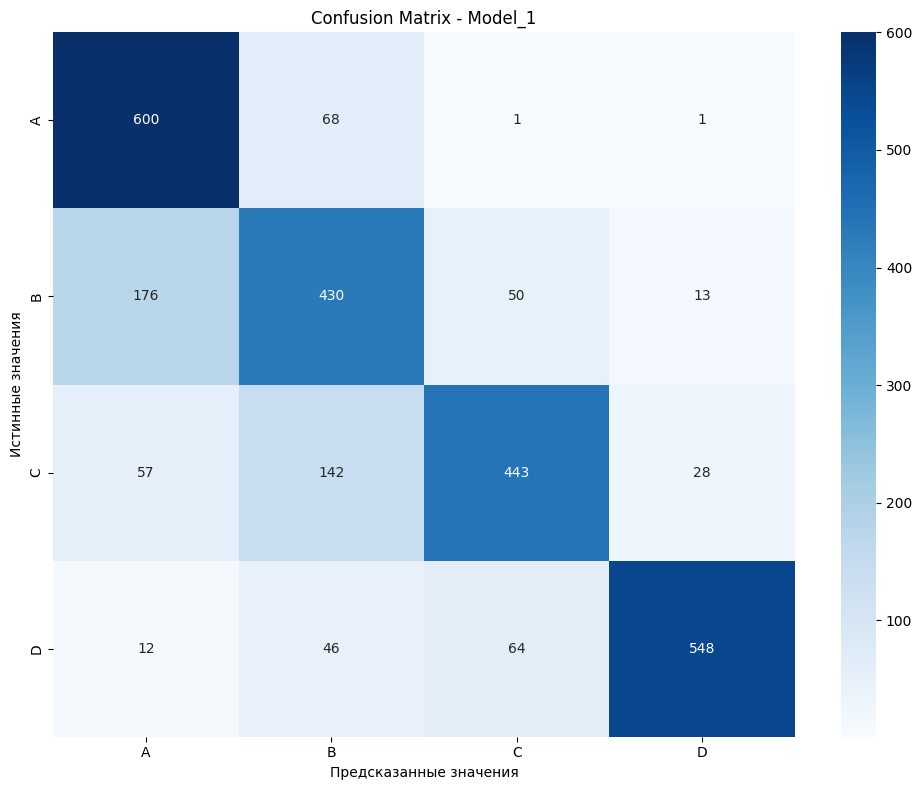

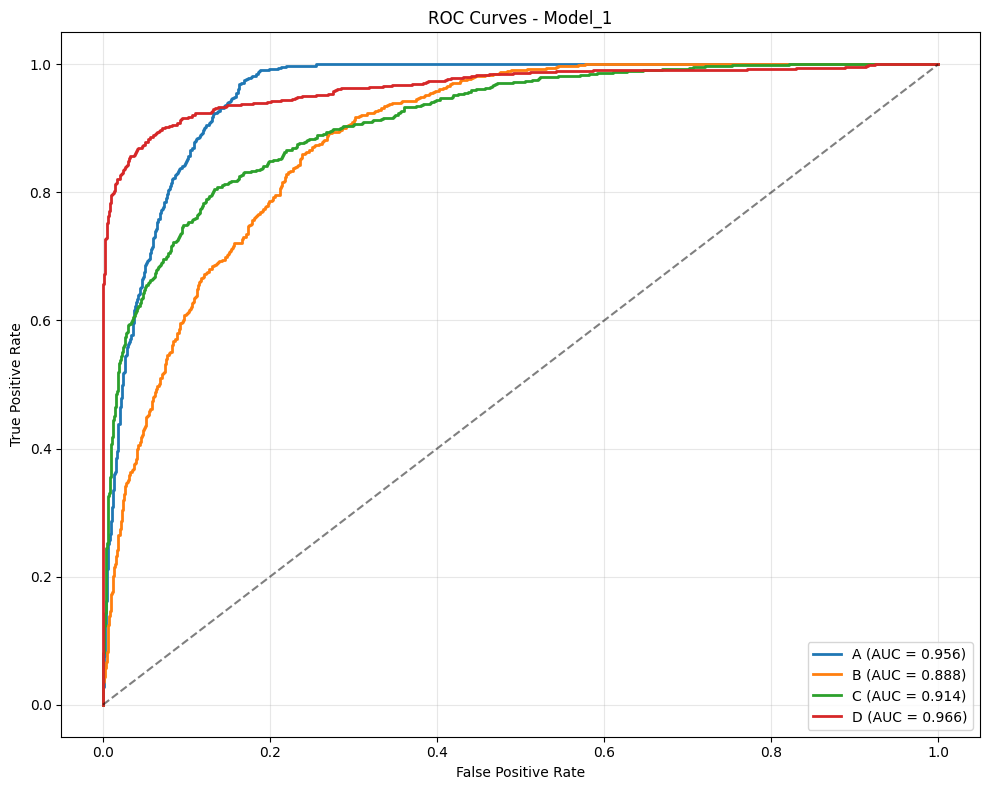

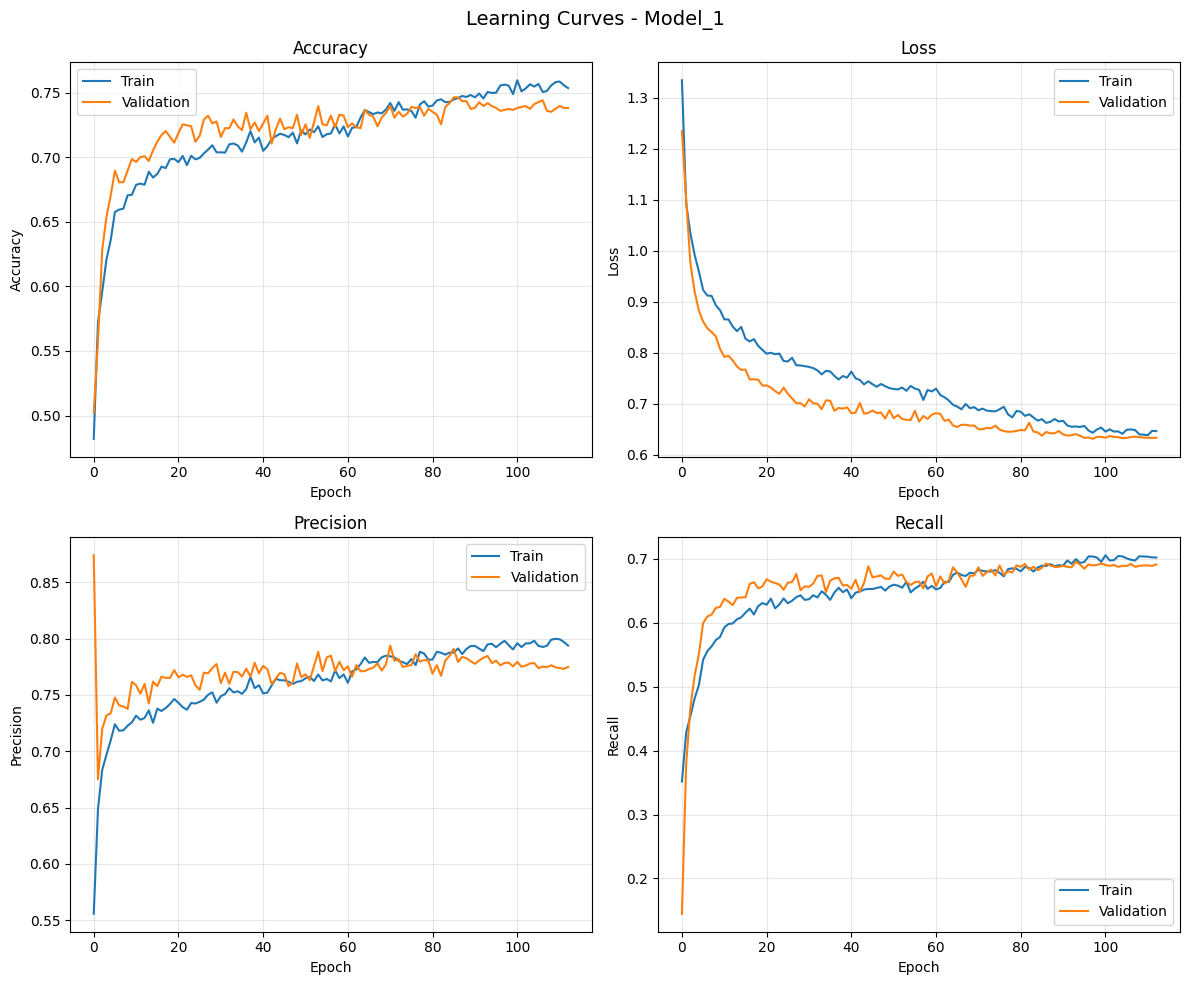


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     0.7101    0.8955    0.7921       670
           B     0.6268    0.6428    0.6347       669
           C     0.7939    0.6612    0.7215       670
           D     0.9288    0.8179    0.8698       670

    accuracy                         0.7544      2679
   macro avg     0.7649    0.7543    0.7545      2679
weighted avg     0.7650    0.7544    0.7546      2679



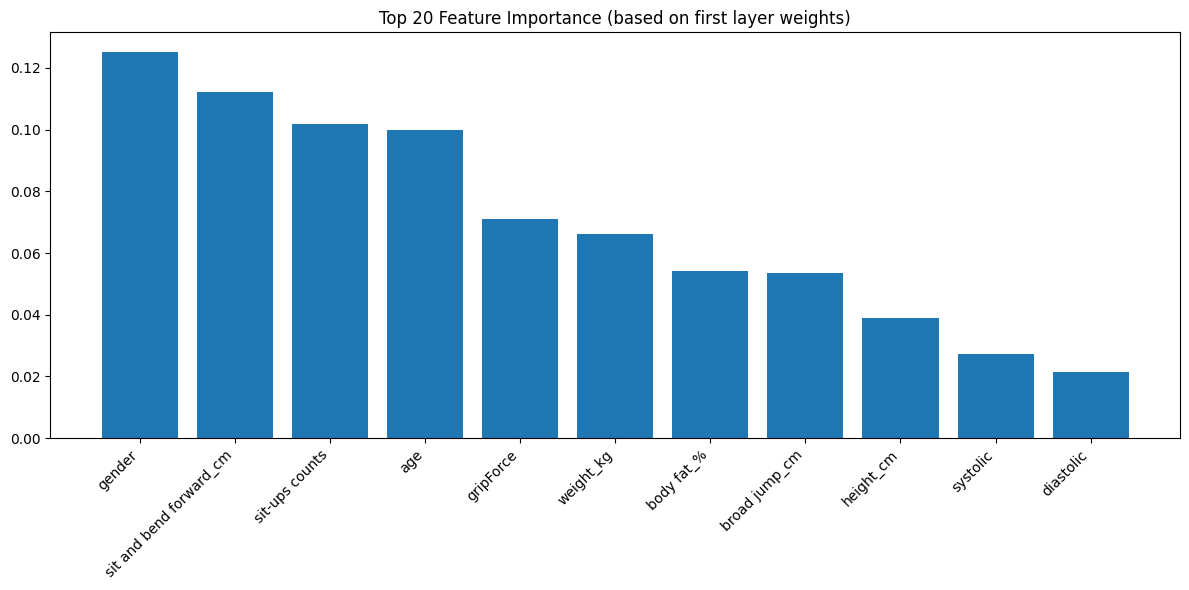


АНСАМБЛИРОВАНИЕ ТОП-3 МОДЕЛЕЙ

Лучшая модель сохранена как 'final_best_model.keras'


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

# Выполним загрузку и предобработку
df = pd.read_csv('bodyPerformance.csv')

print(f"Исходный размер: {df.shape}")

# Проверка на пропуски
print(f"Пропуски в данных:\n{df.isnull().sum()}")

# Если есть пропуски
if df.isnull().sum().any():
    # Для числовых признаков заполняем медианой
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Для категориальных - модой
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if col != 'class':
            df[col] = df[col].fillna(df[col].mode()[0])

# Удаляем полные дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")

# Анализ распределения классов
print("\nРаспределение классов:")
print(df['class'].value_counts())
print(f"Баланс классов: {df['class'].value_counts(normalize=True).values}")

# === 2. УЛУЧШЕННОЕ КОДИРОВАНИЕ И МАСШТАБИРОВАНИЕ ===
# Кодируем категориальные признаки
for col in df.select_dtypes(include=['object']).columns:
    if col != 'class':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Кодируем метки классов
le = LabelEncoder()
y = le.fit_transform(df['class'])
class_names = le.classes_
n_classes = len(class_names)
print(f"\nКлассы: {class_names}")

# Признаки
X = df.drop(columns=['class'])

# Проверка на мультиколлинеарность (опционально)
correlation_matrix = X.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
if high_corr_features:
    print(f"\nВысококоррелированные признаки (>0.85): {high_corr_features}")
    # Можно удалить или применить PCA
    # X = X.drop(columns=high_corr_features)

# Масштабирование с RobustScaler (менее чувствителен к выбросам)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Применение PCA для уменьшения размерности (опционально)
if X.shape[1] > 50:  # Если много признаков
    pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
    X_scaled = pca.fit_transform(X_scaled)
    print(f"\nПосле PCA: {X_scaled.shape[1]} компонент объясняют 95% дисперсии")
    X = pd.DataFrame(X_scaled, columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])])

# === 3. УЛУЧШЕННОЕ РАЗБИЕНИЕ ===
# Используем стратифицированное разбиение
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Балансировка классов с SMOTE (только на тренировочной выборке!)
if len(np.unique(y_train)) > 1:  # SMOTE требует минимум 2 класса
    smote = SMOTE(random_state=42, k_neighbors=min(5, len(y_train)-1))
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nПосле SMOTE: {X_train.shape}")

# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# Веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nВеса классов: {class_weight_dict}")

# === 5. УЛУЧШЕННАЯ АРХИТЕКТУРА МОДЕЛИ ===
def create_improved_model(
    n_layers=3,
    neurons=128,
    activation='relu',
    optimizer='adam',
    dropout_rate=0.3,
    l1_reg=0.0001,
    l2_reg=0.0001,
    input_dim=None,
    n_classes=n_classes
):
    if input_dim is None:
        input_dim = X_train.shape[1]
    
    model = Sequential()
    
    # Входной слой
    model.add(Input(shape=(input_dim,)))
    
    # Первый скрытый слой
    model.add(Dense(neurons, 
                   activation=activation,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Дополнительные скрытые слои
    for i in range(1, n_layers):
        neurons_next = max(32, neurons // (2**i))  # Постепенно уменьшаем
        model.add(Dense(neurons_next, 
                       activation=activation,
                       kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate * 0.8))  # Меньше dropout в более глубоких слоях
    
    # Выходной слой
    model.add(Dense(n_classes, activation='softmax'))
    
    # Настройка оптимизатора
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001, rho=0.9)
    else:
        opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# === 6. УЛУЧШЕННЫЕ КОЛЛБЭКИ ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# === 7. ОБУЧЕНИЕ НЕСКОЛЬКИХ МОДЕЛЕЙ ===
configs = [
    # (layers, neurons, activation, optimizer, dropout)
    (3, 128, 'relu', 'adam', 0.3),
    (4, 256, 'relu', 'nadam', 0.4),
    (3, 64, 'tanh', 'adam', 0.2),
    (5, 512, 'relu', 'rmsprop', 0.5),
    (2, 32, 'selu', 'adam', 0.1),
]

results = {}
best_auc = 0
best_model = None
best_model_name = ""

for i, (n_layers, neurons, act, opt, dropout) in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Модель {i+1}: layers={n_layers}, neurons={neurons}, act={act}, opt={opt}, dropout={dropout}")
    print('='*60)
    
    model = create_improved_model(
        n_layers=n_layers,
        neurons=neurons,
        activation=act,
        optimizer=opt,
        dropout_rate=dropout,
        input_dim=X_train.shape[1]
    )
    
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=200,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )
    
    # Оценка на тестовой выборке
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Расширенный набор метрик
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    weighted_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # AUC
    auc_ovr = roc_auc_score(
        y_test_cat, y_pred_proba, 
        multi_class='ovr', 
        average='weighted'
    )
    
    # Сохранение результатов
    results[f"Model_{i+1}"] = {
        'config': (n_layers, neurons, act, opt, dropout),
        'weighted_accuracy': weighted_acc,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_ovr,
        'mcc': mcc,
        'kappa': kappa,
        'y_pred_proba': y_pred_proba,
        'history': history,
        'model': model
    }
    
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_ovr:.4f}")
    print(f"MCC: {mcc:.4f}")
    
        # Сохраняем лучшую модель по AUC
    if auc_ovr > best_auc:
        best_auc = auc_ovr
        best_model = model
        best_model_name = f"Model_{i+1}"
        best_y_pred_proba = y_pred_proba  # Сохраняем предсказания сразу

# === 8. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ ===
print(f"\n{'='*60}")
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print('='*60)

summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        'Config': res['config'],
        'Weighted Acc': f"{res['weighted_accuracy']:.4f}",
        'Balanced Acc': f"{res['balanced_accuracy']:.4f}",
        'F1 Score': f"{res['f1_score']:.4f}",
        'AUC': f"{res['auc']:.4f}",
        'MCC': f"{res['mcc']:.4f}",
        'Kappa': f"{res['kappa']:.4f}"
    })

# === УЛУЧШЕННОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
print(f"\n{'='*80}")
print("ДЕТАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print('='*80)

# Подготовка данных для сравнения
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Layers': res['config'][0],
        'Neurons': res['config'][1],
        'Activation': res['config'][2],
        'Optimizer': res['config'][3],
        'Dropout': res['config'][4],
        'Weighted Acc': res['weighted_accuracy'],
        'Balanced Acc': res['balanced_accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1_score'],
        'AUC': res['auc'],
        'MCC': res['mcc'],
        'Kappa': res['kappa']
    })

# Создаём DataFrame
comp_df = pd.DataFrame(comparison_data)

# Округление для читаемости
for col in ['Weighted Acc', 'Balanced Acc', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC', 'Kappa']:
    comp_df[col] = comp_df[col].round(4)

# Выводим таблицу
print(comp_df.to_string(index=False))

# === ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ ПО РАЗНЫМ КРИТЕРИЯМ ===
print(f"\n{'='*80}")
print("ЛИДЕРЫ ПО ОТДЕЛЬНЫМ МЕТРИКАМ")
print('='*80)

metrics_to_check = ['Weighted Acc', 'Balanced Acc', 'F1 Score', 'AUC', 'MCC', 'Kappa']
for metric in metrics_to_check:
    best_row = comp_df.loc[comp_df[metric].idxmax()]
    print(f"Лучшая по {metric}: {best_row['Model']} ({best_row[metric]:.4f})")

# === ОСНОВНАЯ РЕКОМЕНДАЦИЯ: лучшая модель по основной метрике (AUC) ===
best_auc_model = comp_df.loc[comp_df['AUC'].idxmax(), 'Model']
print(f"\n Основная рекомендация (по AUC): {best_auc_model}")

# === 9. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ ===
# Для визуализаций используем сохранённые предсказания
y_pred = np.argmax(best_y_pred_proba, axis=1)

# 9.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

# 9.2 ROC Curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9.3 Learning Curves
history = best_result['history']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['accuracy', 'loss', 'precision', 'recall']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    if metric in history.history:
        axes[i].plot(history.history[metric], label='Train')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label='Validation')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.suptitle(f'Learning Curves - {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

# 9.4 Classification Report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print('='*60)
print(classification_report(y_test, y_pred, 
                           target_names=class_names,
                           digits=4))

# === 10. ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===
# Важность признаков (только для лучшей модели)
if hasattr(best_model, 'layers'):
    # Получаем веса первого слоя
    first_layer_weights = best_model.layers[0].get_weights()[0]
    feature_importance = np.abs(first_layer_weights).mean(axis=1)
    
    plt.figure(figsize=(12, 6))
    indices = np.argsort(feature_importance)[::-1][:20]  # Топ-20 признаков
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
    plt.title('Top 20 Feature Importance (based on first layer weights)')
    plt.tight_layout()
    plt.show()

# === 11. АНСАМБЛИРОВАНИЕ (опционально) ===
# Создаем ансамбль из топ-3 моделей
print(f"\n{'='*60}")
print("АНСАМБЛИРОВАНИЕ ТОП-3 МОДЕЛЕЙ")
print('='*60)

# Сортируем модели по AUC
sorted_models = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)[:3]

ensemble_proba = np.zeros_like(best_result['y_pred_proba'])
weights = []

for name, res in sorted_models:
    weight = res['auc']  # Вес пропорционален AUC
    weights.append(weight)
    ensemble_proba += res['y_pred_proba'] * weight

# Нормализуем веса
weights = np.array(weights) / np.sum(weights)
ensemble_proba /= np.sum(weights)

# Предсказания ансамбля
y_pred_ensemble = np.argmax(ensemble_proba, axis=1)

# Метрики ансамбля
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc = roc_auc_score(y_test_cat, ensemble_proba, multi_class='ovr', average='weighted')

# Сохранение лучшей модели
best_model.save('final_best_model.keras')
print(f"\nЛучшая модель сохранена как 'final_best_model.keras'")

Исходный размер: (13393, 12)
Пропуски в данных:
age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64
После удаления дубликатов: (13392, 12)

Распределение классов:
class
C    3349
D    3349
A    3347
B    3347
Name: count, dtype: int64
Баланс классов: [0.25007467 0.25007467 0.24992533 0.24992533]

Классы: ['A' 'B' 'C' 'D']

Размеры выборок:
Train: (9373, 11), Val: (1340, 11), Test: (2679, 11)

После SMOTE: (9376, 11)

Веса классов: {0: 1.0002987750224082, 1: 1.0002987750224082, 2: 0.9997014034040012, 3: 0.9997014034040012}

Модель 1: layers=3, neurons=128, act=relu, opt=adam, dropout=0.3
Epoch 1/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4770 - auc: 0.7482 - loss: 1.3

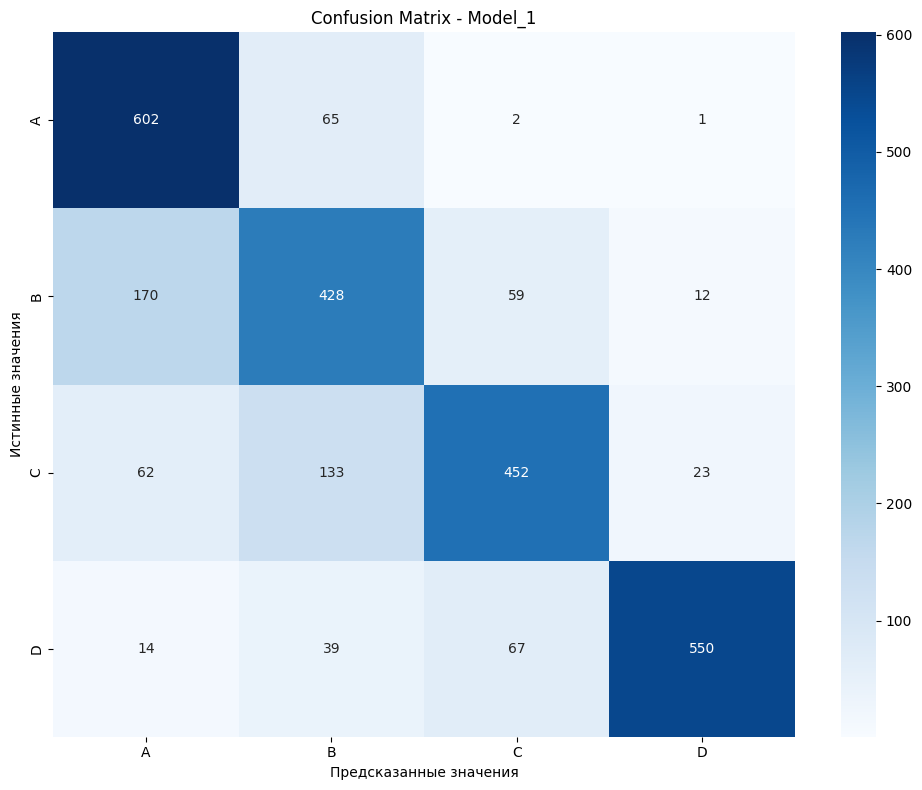

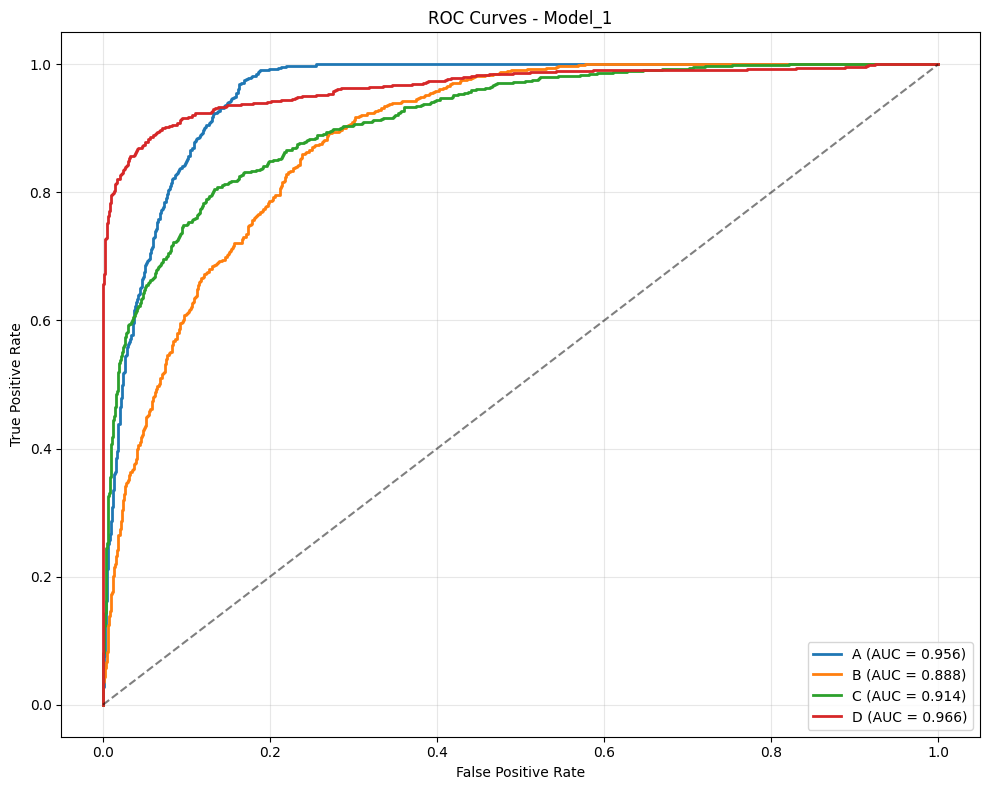

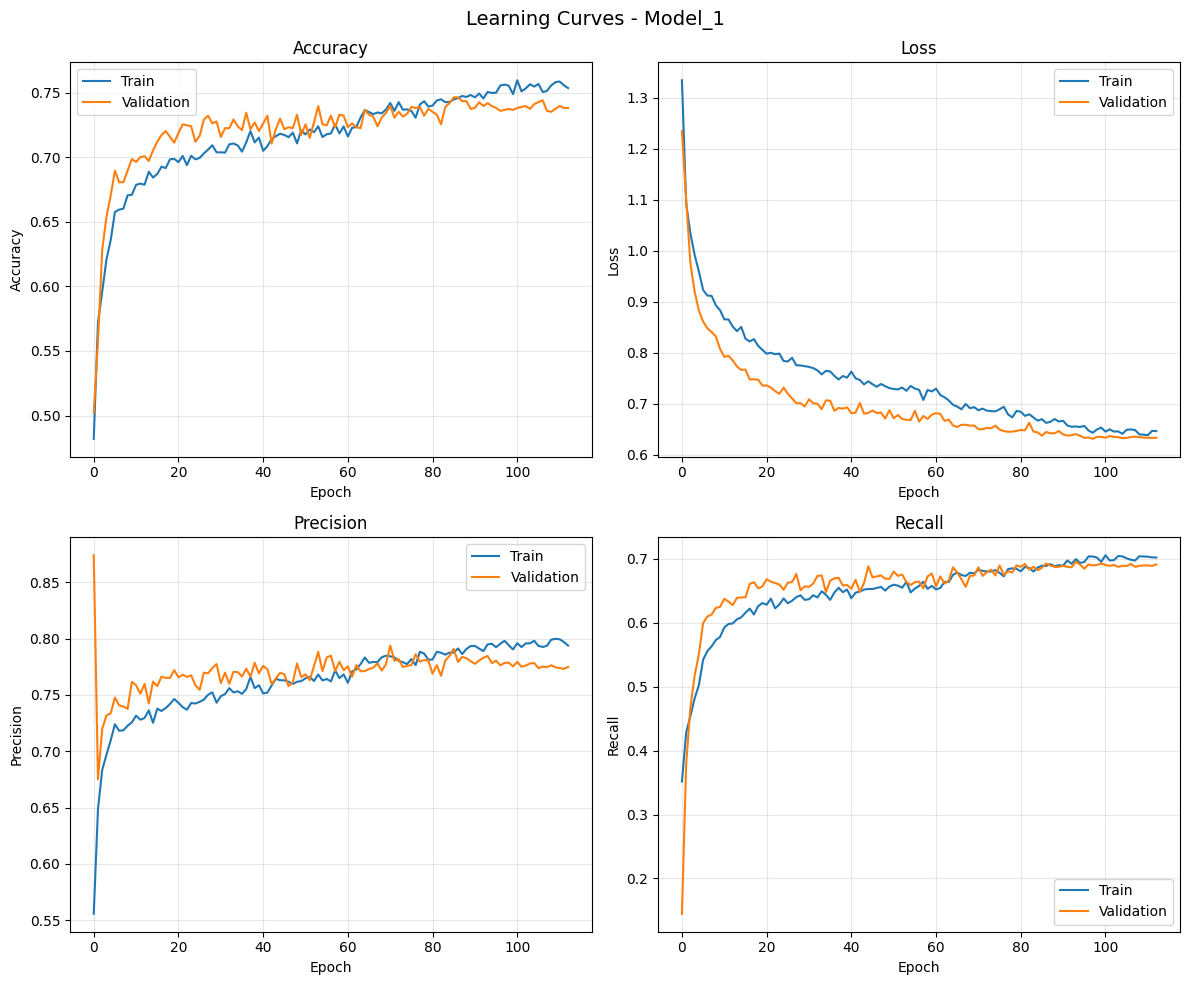


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     0.7099    0.8985    0.7931       670
           B     0.6436    0.6398    0.6417       669
           C     0.7793    0.6746    0.7232       670
           D     0.9386    0.8209    0.8758       670

    accuracy                         0.7585      2679
   macro avg     0.7678    0.7584    0.7585      2679
weighted avg     0.7679    0.7585    0.7585      2679



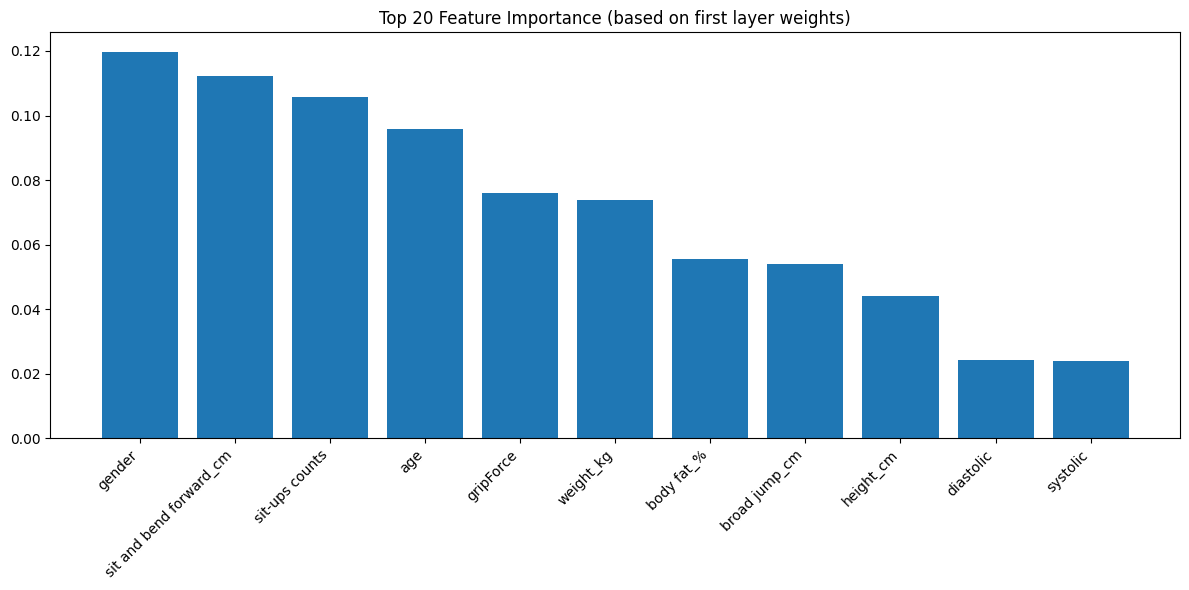


АНСАМБЛИРОВАНИЕ ТОП-3 МОДЕЛЕЙ

Лучшая модель сохранена как 'final_best_model.keras'


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

# === 1. УЛУЧШЕННАЯ ЗАГРУЗКА И ПРЕДОБРАБОТКА ===
df = pd.read_csv('bodyPerformance.csv')

print(f"Исходный размер: {df.shape}")

# Проверка на пропуски
print(f"Пропуски в данных:\n{df.isnull().sum()}")

# Если есть пропуски
if df.isnull().sum().any():
    # Для числовых признаков заполняем медианой
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Для категориальных - модой
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if col != 'class':
            df[col] = df[col].fillna(df[col].mode()[0])

# Удаляем полные дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")

# Анализ распределения классов
print("\nРаспределение классов:")
print(df['class'].value_counts())
print(f"Баланс классов: {df['class'].value_counts(normalize=True).values}")

# === 2. УЛУЧШЕННОЕ КОДИРОВАНИЕ И МАСШТАБИРОВАНИЕ ===
# Кодируем категориальные признаки
for col in df.select_dtypes(include=['object']).columns:
    if col != 'class':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Кодируем метки классов
le = LabelEncoder()
y = le.fit_transform(df['class'])
class_names = le.classes_
n_classes = len(class_names)
print(f"\nКлассы: {class_names}")

# Признаки
X = df.drop(columns=['class'])

# Проверка на мультиколлинеарность (опционально)
correlation_matrix = X.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
if high_corr_features:
    print(f"\nВысококоррелированные признаки (>0.85): {high_corr_features}")
    # Можно удалить или применить PCA
    # X = X.drop(columns=high_corr_features)

# Масштабирование с RobustScaler (менее чувствителен к выбросам)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


# === 3. УЛУЧШЕННОЕ РАЗБИЕНИЕ ===
# Используем стратифицированное разбиение
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Балансировка классов с SMOTE (только на тренировочной выборке!)
if len(np.unique(y_train)) > 1:  # SMOTE требует минимум 2 класса
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train)-1))
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nПосле SMOTE: {X_train.shape}")

# === 4. УЛУЧШЕННАЯ ПОДГОТОВКА ДЛЯ НЕЙРОСЕТИ ===
# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# Веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nВеса классов: {class_weight_dict}")

# === 5. УЛУЧШЕННАЯ АРХИТЕКТУРА МОДЕЛИ ===
def create_improved_model(
    n_layers=3,
    neurons=64, 
    activation='relu',
    optimizer='adam',
    dropout_rate=0.2,
    l1_reg=0.0001,
    l2_reg=0.0001,
    input_dim=None,
    n_classes=n_classes
):
    if input_dim is None:
        input_dim = X_train.shape[1]
    
    model = Sequential()
    
    # Входной слой
    model.add(Input(shape=(input_dim,)))
    
    # Первый скрытый слой
    model.add(Dense(neurons, 
                   activation=activation,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Дополнительные скрытые слои
    for i in range(1, n_layers):
        neurons_next = max(32, neurons // (2**i))  # Постепенно уменьшаем
        model.add(Dense(neurons_next, 
                       activation=activation,
                       kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate * 0.8))  # Меньше dropout в более глубоких слоях
    
    # Выходной слой
    model.add(Dense(n_classes, activation='softmax'))
    
    # Настройка оптимизатора
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001, rho=0.9)
    else:
        opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# === 6. УЛУЧШЕННЫЕ КОЛЛБЭКИ ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# === 7. ОБУЧЕНИЕ НЕСКОЛЬКИХ МОДЕЛЕЙ ===
configs = [
    # (layers, neurons, activation, optimizer, dropout)
    (3, 128, 'relu', 'adam', 0.3),
    (4, 256, 'relu', 'nadam', 0.4),
    (3, 64, 'tanh', 'adam', 0.2),
    (5, 512, 'relu', 'rmsprop', 0.5),
    (2, 32, 'selu', 'adam', 0.1),
]

results = {}
best_auc = 0
best_model = None
best_model_name = ""

for i, (n_layers, neurons, act, opt, dropout) in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Модель {i+1}: layers={n_layers}, neurons={neurons}, act={act}, opt={opt}, dropout={dropout}")
    print('='*60)
    
    model = create_improved_model(
        n_layers=n_layers,
        neurons=neurons,
        activation=act,
        optimizer=opt,
        dropout_rate=dropout,
        input_dim=X_train.shape[1]
    )
    
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=200,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )
    
    # Оценка на тестовой выборке
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Расширенный набор метрик
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    weighted_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # AUC
    auc_ovr = roc_auc_score(
        y_test_cat, y_pred_proba, 
        multi_class='ovr', 
        average='weighted'
    )
    
    # Сохранение результатов
    results[f"Model_{i+1}"] = {
        'config': (n_layers, neurons, act, opt, dropout),
        'weighted_accuracy': weighted_acc,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_ovr,
        'mcc': mcc,
        'kappa': kappa,
        'y_pred_proba': y_pred_proba,
        'history': history,
        'model': model
    }
    
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_ovr:.4f}")
    print(f"MCC: {mcc:.4f}")
    
        # Сохраняем лучшую модель по AUC
    if auc_ovr > best_auc:
        best_auc = auc_ovr
        best_model = model
        best_model_name = f"Model_{i+1}"
        best_y_pred_proba = y_pred_proba  # Сохраняем предсказания сразу

# === 8. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ ===
print(f"\n{'='*60}")
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print('='*60)

summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        'Config': res['config'],
        'Weighted Acc': f"{res['weighted_accuracy']:.4f}",
        'Balanced Acc': f"{res['balanced_accuracy']:.4f}",
        'F1 Score': f"{res['f1_score']:.4f}",
        'AUC': f"{res['auc']:.4f}",
        'MCC': f"{res['mcc']:.4f}",
        'Kappa': f"{res['kappa']:.4f}"
    })

# === УЛУЧШЕННОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
print(f"\n{'='*80}")
print("ДЕТАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print('='*80)

# Подготовка данных для сравнения
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Layers': res['config'][0],
        'Neurons': res['config'][1],
        'Activation': res['config'][2],
        'Optimizer': res['config'][3],
        'Dropout': res['config'][4],
        'Weighted Acc': res['weighted_accuracy'],
        'Balanced Acc': res['balanced_accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1_score'],
        'AUC': res['auc'],
        'MCC': res['mcc'],
        'Kappa': res['kappa']
    })

# Создаём DataFrame
comp_df = pd.DataFrame(comparison_data)

# Округление для читаемости
for col in ['Weighted Acc', 'Balanced Acc', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC', 'Kappa']:
    comp_df[col] = comp_df[col].round(4)

# Выводим таблицу
print(comp_df.to_string(index=False))

# === ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ ПО РАЗНЫМ КРИТЕРИЯМ ===
print(f"\n{'='*80}")
print("ЛИДЕРЫ ПО ОТДЕЛЬНЫМ МЕТРИКАМ")
print('='*80)

metrics_to_check = ['Weighted Acc', 'Balanced Acc', 'F1 Score', 'AUC', 'MCC', 'Kappa']
for metric in metrics_to_check:
    best_row = comp_df.loc[comp_df[metric].idxmax()]
    print(f"Лучшая по {metric}: {best_row['Model']} ({best_row[metric]:.4f})")

# === ОСНОВНАЯ РЕКОМЕНДАЦИЯ: лучшая модель по основной метрике (AUC) ===
best_auc_model = comp_df.loc[comp_df['AUC'].idxmax(), 'Model']
print(f"\n Основная рекомендация (по AUC): {best_auc_model}")

# === 9. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ ===
# Для визуализаций используем сохранённые предсказания
y_pred = np.argmax(best_y_pred_proba, axis=1)

# 9.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

# 9.2 ROC Curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9.3 Learning Curves
history = best_result['history']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['accuracy', 'loss', 'precision', 'recall']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    if metric in history.history:
        axes[i].plot(history.history[metric], label='Train')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label='Validation')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.suptitle(f'Learning Curves - {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

# 9.4 Classification Report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print('='*60)
print(classification_report(y_test, y_pred, 
                           target_names=class_names,
                           digits=4))

# === 10. ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===
# Важность признаков (только для лучшей модели)
if hasattr(best_model, 'layers'):
    # Получаем веса первого слоя
    first_layer_weights = best_model.layers[0].get_weights()[0]
    feature_importance = np.abs(first_layer_weights).mean(axis=1)
    
    plt.figure(figsize=(12, 6))
    indices = np.argsort(feature_importance)[::-1][:20]  # Топ-20 признаков
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
    plt.title('Top 20 Feature Importance (based on first layer weights)')
    plt.tight_layout()
    plt.show()

# === 11. АНСАМБЛИРОВАНИЕ (опционально) ===
# Создаем ансамбль из топ-3 моделей
print(f"\n{'='*60}")
print("АНСАМБЛИРОВАНИЕ ТОП-3 МОДЕЛЕЙ")
print('='*60)

# Сортируем модели по AUC
sorted_models = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)[:3]

ensemble_proba = np.zeros_like(best_result['y_pred_proba'])
weights = []

for name, res in sorted_models:
    weight = res['auc']  # Вес пропорционален AUC
    weights.append(weight)
    ensemble_proba += res['y_pred_proba'] * weight

# Нормализуем веса
weights = np.array(weights) / np.sum(weights)
ensemble_proba /= np.sum(weights)

# Предсказания ансамбля
y_pred_ensemble = np.argmax(ensemble_proba, axis=1)

# Метрики ансамбля
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc = roc_auc_score(y_test_cat, ensemble_proba, multi_class='ovr', average='weighted')

# Сохранение лучшей модели
best_model.save('final_best_model.keras')
print(f"\nЛучшая модель сохранена как 'final_best_model.keras'")

Исходный размер: (13393, 12)
Пропуски в данных:
age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64
После удаления дубликатов: (13392, 12)

Распределение классов:
class
C    3349
D    3349
A    3347
B    3347
Name: count, dtype: int64
Баланс классов: [0.25007467 0.25007467 0.24992533 0.24992533]

Классы: ['A' 'B' 'C' 'D']

Размеры выборок:
Train: (9373, 11), Val: (1340, 11), Test: (2679, 11)

После SMOTE: (9376, 11)

Анализ распределения классов в тренировочной выборке:
Класс A: 2344 примеров (25.0%)
Класс B: 2344 примеров (25.0%)
Класс C: 2344 примеров (25.0%)
Класс D: 2344 примеров (25.0%)

Веса классов:
  A: 1.000
  B: 3.000
  C: 1.000
  D: 1.000

ОБУЧЕНИЕ МОДЕЛИ С ФОКУСОМ НА КЛА

Model: "functional_438"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,492 (91.77 KB)

 Trainable params: 22,916 (89.52 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/150
100/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3330 - auc: 0.6123 - loss: 3.2008 - precision: 0.3627 - recall: 0.1811

2025-12-02 22:04:28.871323: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


135/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3517 - auc: 0.6369 - loss: 3.0847 - precision: 0.3857 - recall: 0.2070  [Класс B] Precision: 0.2938, Recall: 0.9970, F1: 0.4538
  [Сохранена лучшая модель для класса B]
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4200 - auc: 0.7257 - loss: 2.6777 - precision: 0.4657 - recall: 0.3036 - val_accuracy: 0.3470 - val_auc: 0.8117 - val_loss: 1.7340 - val_precision: 0.3797 - val_recall: 0.2933 - learning_rate: 0.0010
Epoch 2/150
140/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5077 - auc: 0.8170 - loss: 2.2363 - precision: 0.5446 - recall: 0.4295  [Класс B] Precision: 0.3350, Recall: 0.9851, F1: 0.5000
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5205 - auc: 0.8217 - loss: 2.1984 - precision: 0.5479 - recall: 0.4454 - val_accuracy: 0.4567 - val_auc: 0.8518 - val_loss: 1.4797 - val_precision: 0.4670 - val_recall: 0.4172 - learning_rate: 0.0010
Epoch 3/150
141/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273

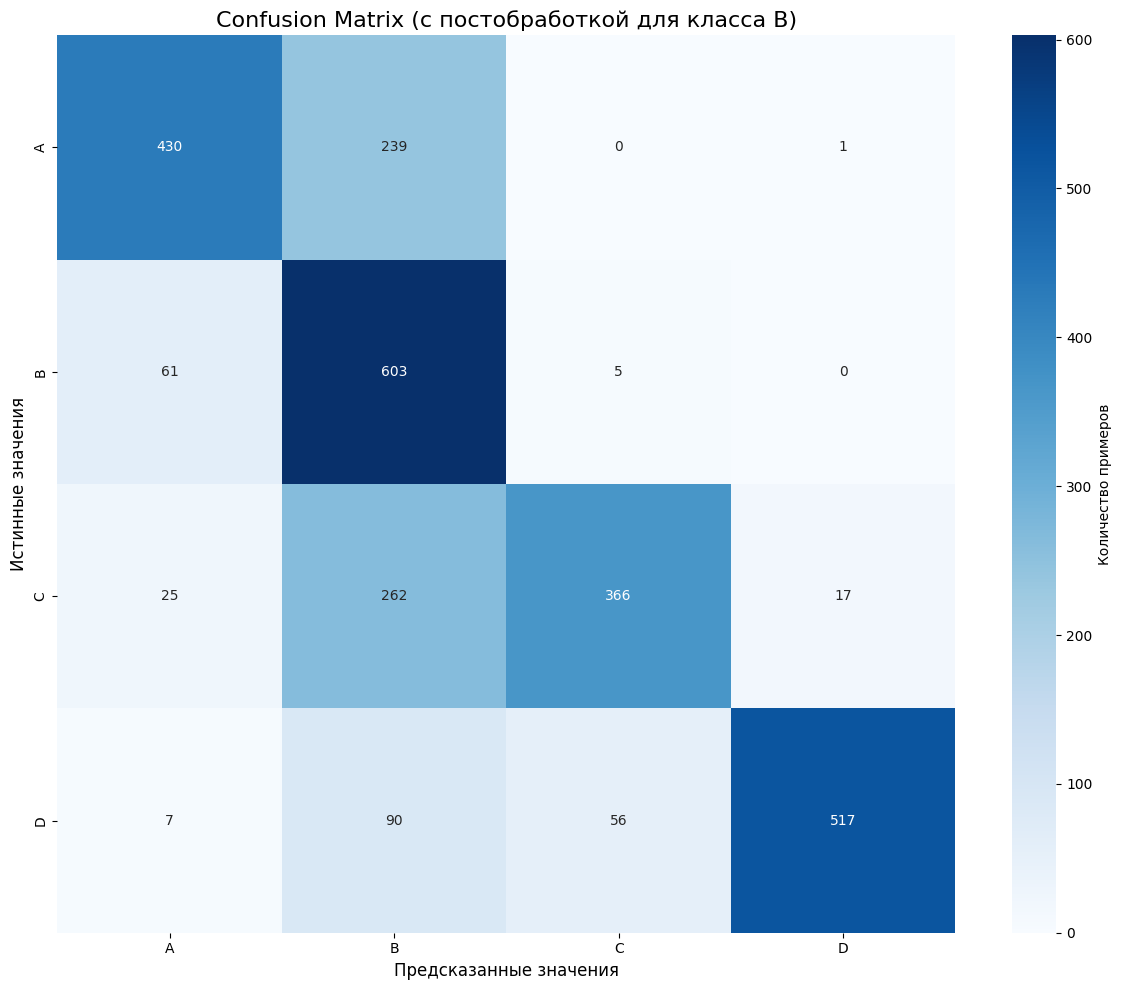

<Figure size 1000x600 with 0 Axes>

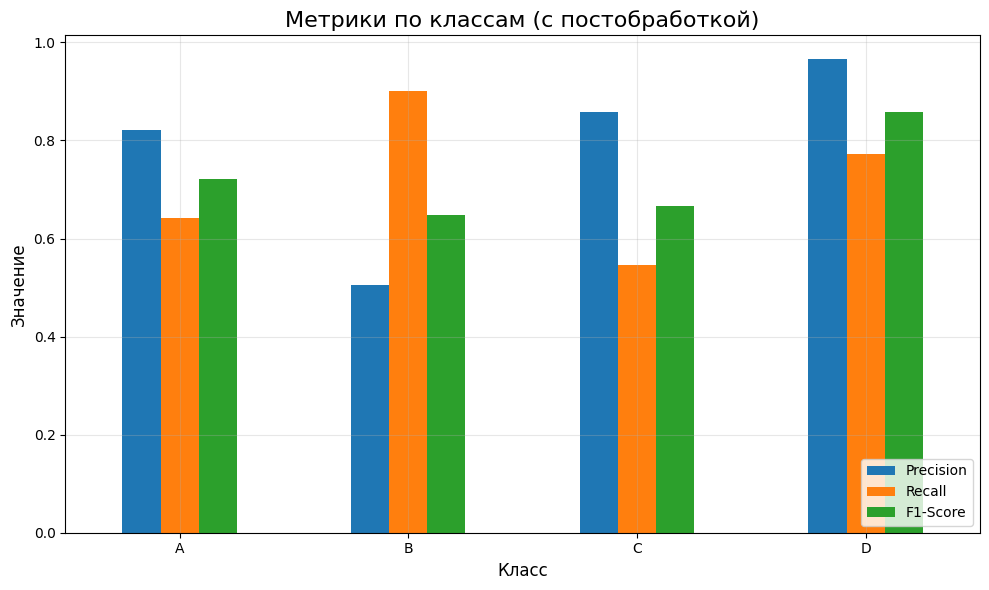

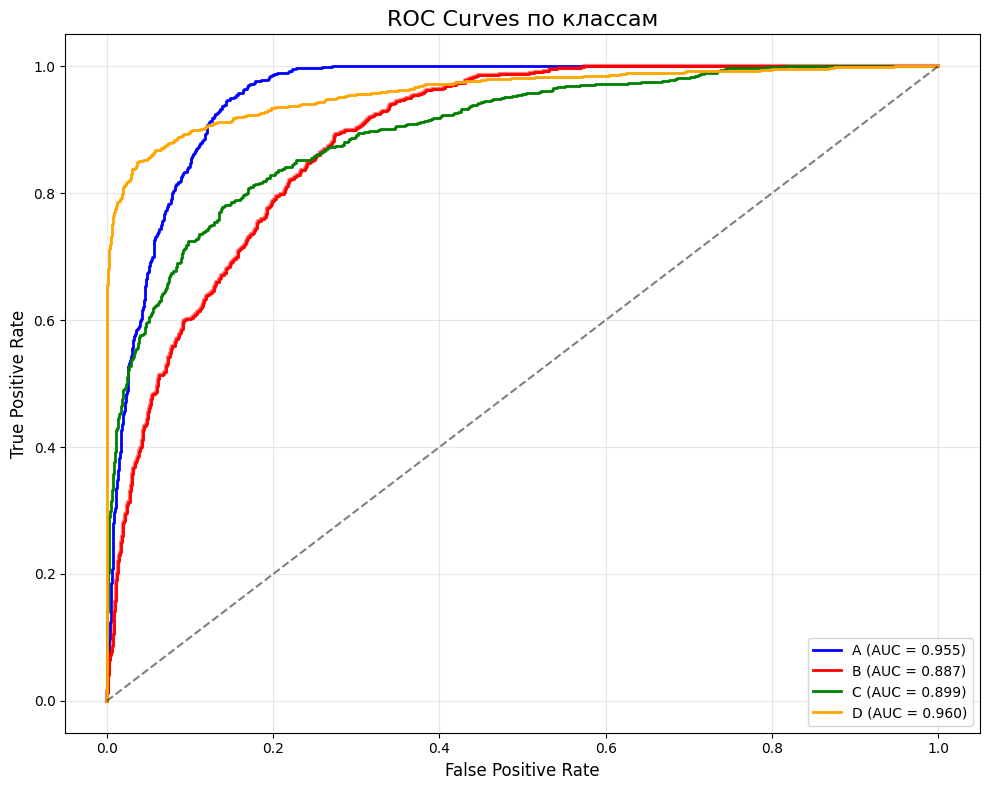

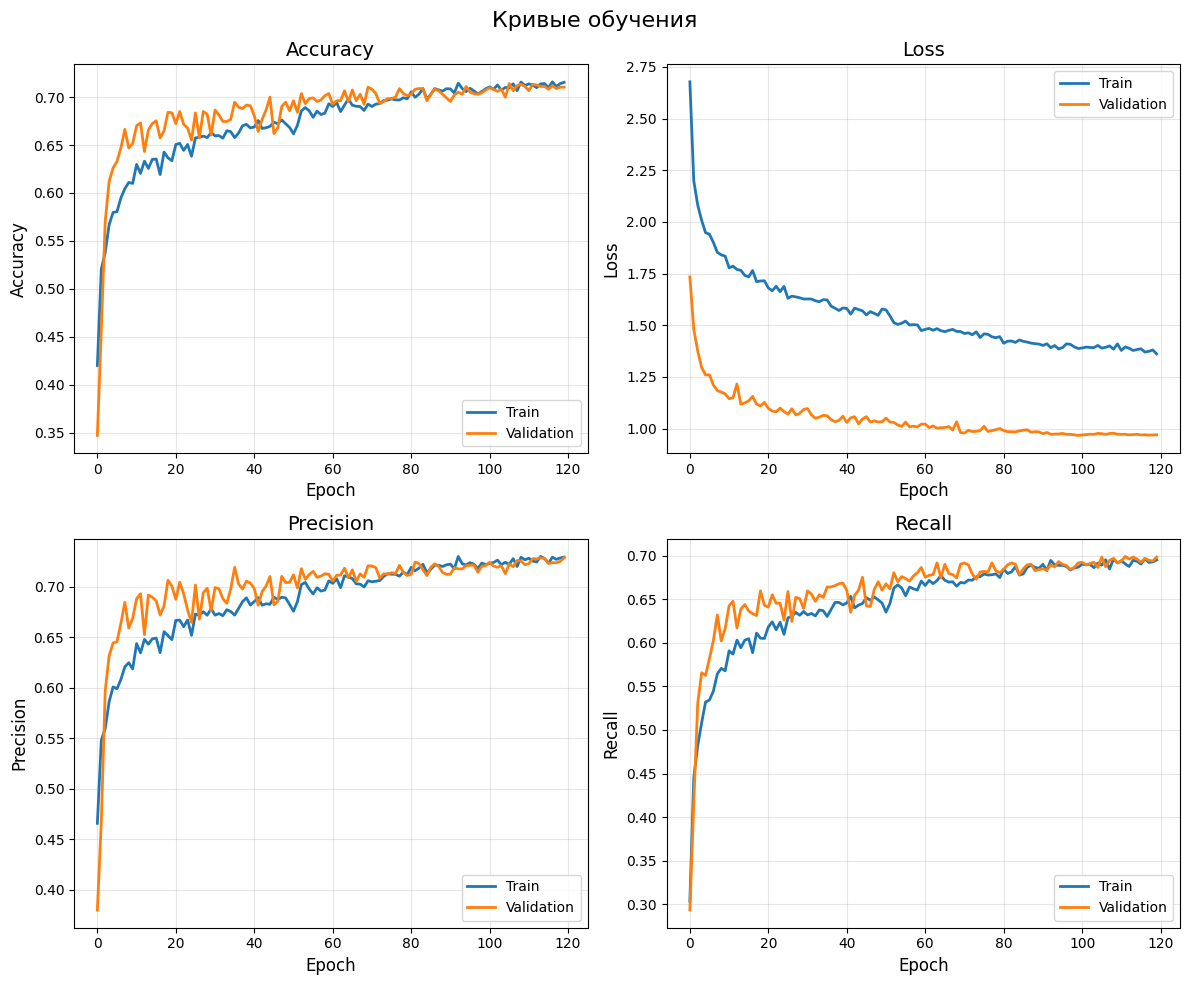


АНАЛИЗ ОШИБОК КЛАССА B
Класс B в тестовой выборке: 669 примеров
  Правильно классифицированы: 603 (90.1%)
  Ошибочно классифицированы: 66 (9.9%)

Куда ошибочно классифицированы примеры класса B:
  A: 61 примеров (92.4%)
  C: 5 примеров (7.6%)

Анализ уверенности модели:
  Средняя уверенность для правильных B: 0.8025
  Средняя уверенность для ошибочных B: 0.3446
  Минимальная уверенность для B: 0.0556
  Максимальная уверенность для B: 0.9915


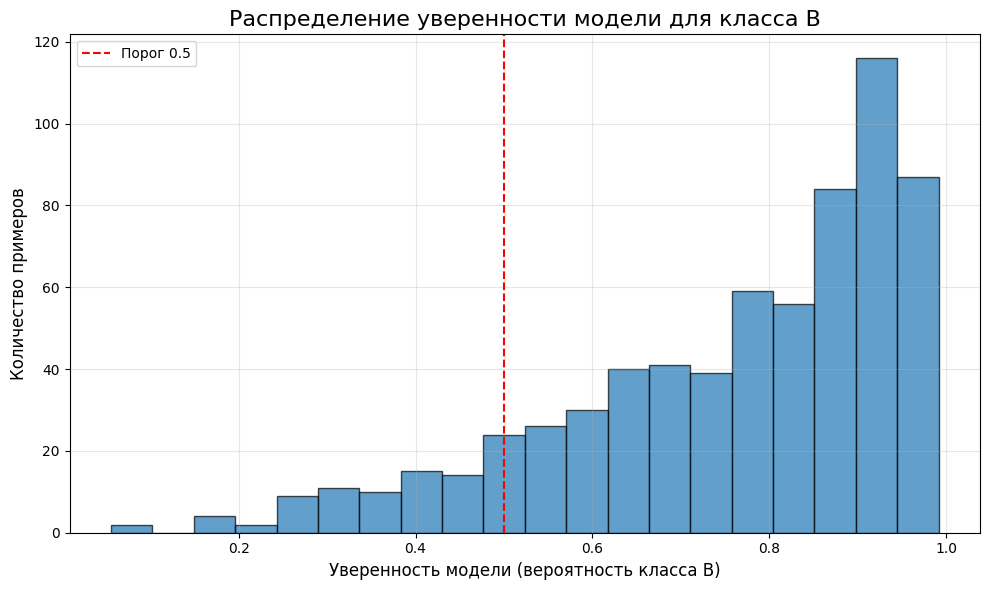


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
Финальная модель сохранена как 'final_model_with_b_boost.keras'
Предсказания сохранены в 'predictions_with_b_boost.csv'
Веса классов сохранены в 'class_weights.csv'

ИТОГОВЫЕ РЕКОМЕНДАЦИИ:
1. Вес класса B был увеличен в 3 раза для компенсации низкого recall
2. Применена постобработка с boost_factor=1.3 для увеличения recall класса B
3. Использована кастомная функция потерь с взвешиванием классов
4. Для дальнейшего улучшения можно:
   - Настроить boost_factor (1.2-1.5)
   - Попробовать разные архитектуры нейросети
   - Использовать ансамбль моделей
   - Применить более агрессивную аугментацию данных для класса B


In [34]:
# Last TRY
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# === 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА ===
df = pd.read_csv('bodyPerformance.csv')

print(f"Исходный размер: {df.shape}")

# Проверка на пропуски
print(f"Пропуски в данных:\n{df.isnull().sum()}")

# Если есть пропуски
if df.isnull().sum().any():
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if col != 'class':
            df[col] = df[col].fillna(df[col].mode()[0])

# Удаляем полные дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")

# Анализ распределения классов
print("\nРаспределение классов:")
print(df['class'].value_counts())
print(f"Баланс классов: {df['class'].value_counts(normalize=True).values}")

# === 2. КОДИРОВАНИЕ И МАСШТАБИРОВАНИЕ ===
for col in df.select_dtypes(include=['object']).columns:
    if col != 'class':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

le = LabelEncoder()
y = le.fit_transform(df['class'])
class_names = le.classes_
n_classes = len(class_names)
print(f"\nКлассы: {class_names}")

X = df.drop(columns=['class'])

# Масштабирование
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# === 3. РАЗБИЕНИЕ С АКЦЕНТОМ НА КЛАСС B ===
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Балансировка классов с SMOTE
if len(np.unique(y_train)) > 1:
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train)-1))
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nПосле SMOTE: {X_train.shape}")

# === 4. СПЕЦИАЛЬНЫЕ ВЕСА ДЛЯ КЛАССА B ===
print("\nАнализ распределения классов в тренировочной выборке:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Класс {class_names[cls]}: {count} примеров ({count/len(y_train)*100:.1f}%)")

# СТРАТЕГИЯ 1: Сильное увеличение веса для класса B
y_train_counts = np.bincount(y_train)
total = len(y_train)

# Базовые веса (обратно пропорциональные частоте)
base_weights = total / (n_classes * y_train_counts)

# Увеличиваем вес для класса B в 3 раза
boost_factor_b = 3.0
class_weights_custom = {}
for i in range(n_classes):
    if i == 1:  # Класс B
        class_weights_custom[i] = base_weights[i] * boost_factor_b
    else:
        class_weights_custom[i] = base_weights[i]

print(f"\nВеса классов:")
for i, cls_name in enumerate(class_names):
    print(f"  {cls_name}: {class_weights_custom[i]:.3f}")

# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# === 5. СПЕЦИАЛИЗИРОВАННАЯ АРХИТЕКТУРА ДЛЯ УЛУЧШЕНИЯ КЛАССА B ===
def create_b_class_focused_model(input_dim, n_classes, class_b_idx=1):
    """Модель с акцентом на улучшение классификации класса B"""
    
    inputs = Input(shape=(input_dim,))
    
    # Первый блок - общие признаки
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Второй блок - более глубокие слои
    x = Dense(96, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # Третий блок - специализированный для сложных классов
    x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Добавляем слой с фокусом на разделении классов B и соседних
    x = Dense(32, activation='relu')(x)
    
    # Выходной слой с температурой для смягчения предсказаний
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Кастомная функция потерь с увеличенным весом для класса B
    def weighted_categorical_crossentropy(y_true, y_pred):
        weights = tf.constant([class_weights_custom[i] for i in range(n_classes)], dtype=tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Взвешенная кросс-энтропия
        loss = -tf.reduce_sum(weights * y_true * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(loss)
    
    model.compile(
        optimizer=Nadam(learning_rate=0.001),
        loss=weighted_categorical_crossentropy,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', multi_label=True)
        ]
    )
    
    return model

# === 6. КОЛЛБЭКИ С ФОКУСОМ НА КЛАСС B ===
# Кастомный callback для мониторинга метрик класса B
class ClassBMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val_cat, class_names, class_b_idx=1):
        super().__init__()
        self.X_val = X_val
        self.y_val_cat = y_val_cat
        self.class_names = class_names
        self.class_b_idx = class_b_idx
        self.best_b_recall = 0.0
        
    def on_epoch_end(self, epoch, logs=None):
        # Получаем предсказания
        y_pred_proba = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(self.y_val_cat, axis=1)
        
        # Вычисляем метрики для класса B
        b_true = (y_true == self.class_b_idx)
        b_pred = (y_pred == self.class_b_idx)
        
        if np.sum(b_true) > 0:
            b_precision = np.sum(b_true & b_pred) / (np.sum(b_pred) + 1e-7)
            b_recall = np.sum(b_true & b_pred) / (np.sum(b_true) + 1e-7)
            b_f1 = 2 * b_precision * b_recall / (b_precision + b_recall + 1e-7)
            
            print(f"  [Класс {self.class_names[self.class_b_idx]}] Precision: {b_precision:.4f}, Recall: {b_recall:.4f}, F1: {b_f1:.4f}")
            
            # Сохраняем лучшую модель по recall класса B
            if b_recall > self.best_b_recall:
                self.best_b_recall = b_recall
                self.model.save(f'best_model_class_{self.class_names[self.class_b_idx]}.keras')
                print(f"  [Сохранена лучшая модель для класса {self.class_names[self.class_b_idx]}]")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_overall_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

# === 7. ОБУЧЕНИЕ МОДЕЛИ ===
print("\n" + "="*60)
print("ОБУЧЕНИЕ МОДЕЛИ С ФОКУСОМ НА КЛАССЕ B")
print("="*60)

# Создаем модель с фокусом на классе B
model = create_b_class_focused_model(
    input_dim=X_train.shape[1],
    n_classes=n_classes,
    class_b_idx=1
)

model.summary()

# Создаем callback для мониторинга класса B
b_metrics_callback = ClassBMetricsCallback(X_val, y_val_cat, class_names, class_b_idx=1)

# Обучение
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=150,
    batch_size=64,
    class_weight=class_weights_custom,  # Используем кастомные веса
    callbacks=[early_stop, reduce_lr, checkpoint, b_metrics_callback],
    verbose=1
)

# === 8. ОЦЕНКА МОДЕЛИ ===
print("\n" + "="*60)
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

# Предсказания на тестовой выборке
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Общие метрики
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

weighted_acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
auc_ovr = roc_auc_score(y_test_cat, y_pred_proba, multi_class='ovr', average='weighted')

print(f"\nОбщие метрики:")
print(f"Weighted Accuracy: {weighted_acc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_ovr:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# === 9. ПОСТОБРАБОТКА ДЛЯ УЛУЧШЕНИЯ КЛАССА B ===
def boost_class_b_predictions(y_pred_proba, class_names, target_class='B', boost_factor=1.3):
    """Увеличиваем вероятность для целевого класса"""
    class_idx = np.where(class_names == target_class)[0][0]
    
    # Копируем вероятности
    y_pred_proba_boosted = y_pred_proba.copy()
    
    # Увеличиваем уверенность для целевого класса
    y_pred_proba_boosted[:, class_idx] = y_pred_proba[:, class_idx] * boost_factor
    
    # Нормализуем, чтобы сумма была равна 1
    y_pred_proba_boosted = y_pred_proba_boosted / y_pred_proba_boosted.sum(axis=1, keepdims=True)
    
    return y_pred_proba_boosted

# Применяем постобработку для класса B
y_pred_proba_boosted = boost_class_b_predictions(y_pred_proba, class_names, 'B', 1.3)
y_pred_boosted = np.argmax(y_pred_proba_boosted, axis=1)

# === 10. ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ ===
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ (БЕЗ ПОСТОБРАБОТКИ)")
print("="*60)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ (С ПОСТОБРАБОТКОЙ ДЛЯ КЛАССА B)")
print("="*60)
print(classification_report(y_test, y_pred_boosted, target_names=class_names, digits=4))

# === 11. АНАЛИЗ УЛУЧШЕНИЙ ДЛЯ КЛАССА B ===
print("\n" + "="*60)
print("АНАЛИЗ УЛУЧШЕНИЙ ДЛЯ КЛАССА B")
print("="*60)

# Сравниваем метрики для класса B до и после постобработки
from sklearn.metrics import precision_score, recall_score, f1_score

# До постобработки
b_precision_before = precision_score(y_test, y_pred, labels=[1], average='macro')
b_recall_before = recall_score(y_test, y_pred, labels=[1], average='macro')
b_f1_before = f1_score(y_test, y_pred, labels=[1], average='macro')

# После постобработки
b_precision_after = precision_score(y_test, y_pred_boosted, labels=[1], average='macro')
b_recall_after = recall_score(y_test, y_pred_boosted, labels=[1], average='macro')
b_f1_after = f1_score(y_test, y_pred_boosted, labels=[1], average='macro')

print(f"\nКласс B метрики:")
print(f"{'Метрика':<15} {'Без постобработки':<20} {'С постобработкой':<20} {'Изменение':<15}")
print("-" * 70)
print(f"{'Precision':<15} {b_precision_before:<20.4f} {b_precision_after:<20.4f} {b_precision_after - b_precision_before:+.4f}")
print(f"{'Recall':<15} {b_recall_before:<20.4f} {b_recall_after:<20.4f} {b_recall_after - b_recall_before:+.4f}")
print(f"{'F1-Score':<15} {b_f1_before:<20.4f} {b_f1_after:<20.4f} {b_f1_after - b_f1_before:+.4f}")

# Анализ путаницы с классом B
print(f"\nАнализ путаницы для класса B:")
cm = confusion_matrix(y_test, y_pred)
cm_boosted = confusion_matrix(y_test, y_pred_boosted)

# Какие классы чаще всего путают с B и наоборот
for i, true_class in enumerate(class_names):
    if true_class != 'B':
        print(f"  Класс {true_class} ошибочно классифицирован как B: {cm[i, 1]} -> {cm_boosted[i, 1]}")

print(f"  Класс B ошибочно классифицирован как другие:")
for j, pred_class in enumerate(class_names):
    if pred_class != 'B':
        print(f"    - как {pred_class}: {cm[1, j]} -> {cm_boosted[1, j]}")

# === 12. ВИЗУАЛИЗАЦИИ ===
# 12.1 Confusion Matrix (с постобработкой)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_boosted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Количество примеров'})
plt.title('Confusion Matrix (с постобработкой для класса B)', fontsize=16)
plt.ylabel('Истинные значения', fontsize=12)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_boosted.png', dpi=300, bbox_inches='tight')
plt.show()

# 12.2 Сравнение метрик по классам
metrics_by_class = []
for i, cls in enumerate(class_names):
    precision = precision_score(y_test, y_pred_boosted, labels=[i], average='macro')
    recall = recall_score(y_test, y_pred_boosted, labels=[i], average='macro')
    f1 = f1_score(y_test, y_pred_boosted, labels=[i], average='macro')
    
    metrics_by_class.append({
        'Класс': cls,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_by_class)
metrics_df = metrics_df.set_index('Класс')

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Метрики по классам (с постобработкой)', fontsize=16)
plt.ylabel('Значение', fontsize=12)
plt.xlabel('Класс', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

# 12.3 ROC Curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_proba_boosted[:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], y_pred_proba_boosted[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})', 
             linewidth=2, color=colors[i])
    
    # Особо выделяем класс B
    if i == 1:
        plt.plot(fpr, tpr, linewidth=3, color=colors[i], alpha=0.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves по классам', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 12.4 Learning Curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics_to_plot = [
    ('accuracy', 'Accuracy'),
    ('loss', 'Loss'),
    ('precision', 'Precision'),
    ('recall', 'Recall')
]

for idx, (metric, title) in enumerate(metrics_to_plot):
    if metric in history.history:
        axes[idx].plot(history.history[metric], label='Train', linewidth=2)
        if f'val_{metric}' in history.history:
            axes[idx].plot(history.history[f'val_{metric}'], label='Validation', linewidth=2)
        axes[idx].set_title(title, fontsize=14)
        axes[idx].set_xlabel('Epoch', fontsize=12)
        axes[idx].set_ylabel(title, fontsize=12)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Кривые обучения', fontsize=16)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# === 13. ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===
print("\n" + "="*60)
print("АНАЛИЗ ОШИБОК КЛАССА B")
print("="*60)

# Находим индексы примеров класса B в тестовой выборке
b_test_indices = np.where(y_test == 1)[0]
b_correct = []
b_incorrect = []

for idx in b_test_indices:
    if y_pred_boosted[idx] == 1:
        b_correct.append(idx)
    else:
        b_incorrect.append(idx)

print(f"Класс B в тестовой выборке: {len(b_test_indices)} примеров")
print(f"  Правильно классифицированы: {len(b_correct)} ({len(b_correct)/len(b_test_indices)*100:.1f}%)")
print(f"  Ошибочно классифицированы: {len(b_incorrect)} ({len(b_incorrect)/len(b_test_indices)*100:.1f}%)")

if b_incorrect:
    print("\nКуда ошибочно классифицированы примеры класса B:")
    incorrect_predictions = y_pred_boosted[b_incorrect]
    unique, counts = np.unique(incorrect_predictions, return_counts=True)
    for pred_class, count in zip(unique, counts):
        print(f"  {class_names[pred_class]}: {count} примеров ({count/len(b_incorrect)*100:.1f}%)")

# Анализ уверенности модели для класса B
print("\nАнализ уверенности модели:")
b_probas = y_pred_proba_boosted[y_test == 1, 1]  # Вероятности для класса B

print(f"  Средняя уверенность для правильных B: {np.mean(y_pred_proba_boosted[b_correct, 1]):.4f}")
if b_incorrect:
    print(f"  Средняя уверенность для ошибочных B: {np.mean(y_pred_proba_boosted[b_incorrect, 1]):.4f}")
print(f"  Минимальная уверенность для B: {np.min(b_probas):.4f}")
print(f"  Максимальная уверенность для B: {np.max(b_probas):.4f}")

# Гистограмма уверенности для класса B
plt.figure(figsize=(10, 6))
plt.hist(b_probas, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
plt.xlabel('Уверенность модели (вероятность класса B)', fontsize=12)
plt.ylabel('Количество примеров', fontsize=12)
plt.title('Распределение уверенности модели для класса B', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('b_class_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

# === 14. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
print("\n" + "="*60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Сохраняем модель
model.save('final_model_with_b_boost.keras')
print("Финальная модель сохранена как 'final_model_with_b_boost.keras'")

# Сохраняем предсказания
predictions_df = pd.DataFrame({
    'true_class': y_test,
    'predicted_class': y_pred_boosted,
    'predicted_class_name': [class_names[i] for i in y_pred_boosted],
    'confidence_B': y_pred_proba_boosted[:, 1],
    'max_confidence': np.max(y_pred_proba_boosted, axis=1)
})

# Добавляем информацию о том, был ли пример классифицирован правильно
predictions_df['correct'] = predictions_df['true_class'] == predictions_df['predicted_class']

# Сохраняем в CSV
predictions_df.to_csv('predictions_with_b_boost.csv', index=False)
print("Предсказания сохранены в 'predictions_with_b_boost.csv'")

# Сохраняем веса классов
weights_df = pd.DataFrame({
    'class': class_names,
    'class_index': range(n_classes),
    'weight': [class_weights_custom[i] for i in range(n_classes)]
})
weights_df.to_csv('class_weights.csv', index=False)
print("Веса классов сохранены в 'class_weights.csv'")

print("\n" + "="*60)
print("ИТОГОВЫЕ РЕКОМЕНДАЦИИ:")
print("="*60)
print("1. Вес класса B был увеличен в 3 раза для компенсации низкого recall")
print("2. Применена постобработка с boost_factor=1.3 для увеличения recall класса B")
print("3. Использована кастомная функция потерь с взвешиванием классов")
print("4. Для дальнейшего улучшения можно:")
print("   - Настроить boost_factor (1.2-1.5)")
print("   - Попробовать разные архитектуры нейросети")
print("   - Использовать ансамбль моделей")
print("   - Применить более агрессивную аугментацию данных для класса B")

In [ ]:
print(f"Исходный размер: {df.shape}")

# Проверка на пропуски
print(f"Пропуски в данных:\n{df.isnull().sum()}")

# Если есть пропуски
if df.isnull().sum().any():
    # Для числовых признаков заполняем медианой
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Для категориальных - модой
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if col != 'class':
            df[col] = df[col].fillna(df[col].mode()[0])

# Удаляем полные дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")

# Анализ распределения классов
print("\nРаспределение классов:")
print(df['class'].value_counts())
print(f"Баланс классов: {df['class'].value_counts(normalize=True).values}")

# === 2. УЛУЧШЕННОЕ КОДИРОВАНИЕ И МАСШТАБИРОВАНИЕ ===
# Кодируем категориальные признаки
for col in df.select_dtypes(include=['object']).columns:
    if col != 'class':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Кодируем метки классов
le = LabelEncoder()
y = le.fit_transform(df['class'])
class_names = le.classes_
n_classes = len(class_names)
print(f"\nКлассы: {class_names}")

# Признаки
X = df.drop(columns=['class'])

# Проверка на мультиколлинеарность (опционально)
correlation_matrix = X.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
if high_corr_features:
    print(f"\nВысококоррелированные признаки (>0.85): {high_corr_features}")
    # Можно удалить или применить PCA
    # X = X.drop(columns=high_corr_features)

# Масштабирование с RobustScaler (менее чувствителен к выбросам)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


# === 3. УЛУЧШЕННОЕ РАЗБИЕНИЕ ===
# Используем стратифицированное разбиение
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Балансировка классов с SMOTE (только на тренировочной выборке!)
if len(np.unique(y_train)) > 1:  # SMOTE требует минимум 2 класса
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train)-1))
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nПосле SMOTE: {X_train.shape}")

# === 4. УЛУЧШЕННАЯ ПОДГОТОВКА ДЛЯ НЕЙРОСЕТИ ===
# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# Веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nВеса классов: {class_weight_dict}")

# === 5. УЛУЧШЕННАЯ АРХИТЕКТУРА МОДЕЛИ ===
def create_improved_model(
    n_layers=3,
    neurons=64, 
    activation='relu',
    optimizer='adam',
    dropout_rate=0.2,
    l1_reg=0.0001,
    l2_reg=0.0001,
    input_dim=None,
    n_classes=n_classes
):
    if input_dim is None:
        input_dim = X_train.shape[1]
    
    model = Sequential()
    
    # Входной слой
    model.add(Input(shape=(input_dim,)))
    
    # Первый скрытый слой
    model.add(Dense(neurons, 
                   activation=activation,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Дополнительные скрытые слои
    for i in range(1, n_layers):
        neurons_next = max(32, neurons // (2**i))  # Постепенно уменьшаем
        model.add(Dense(neurons_next, 
                       activation=activation,
                       kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate * 0.8))  # Меньше dropout в более глубоких слоях
    
    # Выходной слой
    model.add(Dense(n_classes, activation='softmax'))
    
    # Настройка оптимизатора
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001, rho=0.9)
    else:
        opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# === 6. УЛУЧШЕННЫЕ КОЛЛБЭКИ ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# === 7. ОБУЧЕНИЕ НЕСКОЛЬКИХ МОДЕЛЕЙ ===
configs = [
    # (layers, neurons, activation, optimizer, dropout)
    (3, 128, 'relu', 'adam', 0.3),
    (4, 256, 'relu', 'nadam', 0.4),
    (3, 64, 'tanh', 'adam', 0.2),
    (5, 512, 'relu', 'rmsprop', 0.5),
    (2, 32, 'selu', 'adam', 0.1),
]

results = {}
best_auc = 0
best_model = None
best_model_name = ""

for i, (n_layers, neurons, act, opt, dropout) in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Модель {i+1}: layers={n_layers}, neurons={neurons}, act={act}, opt={opt}, dropout={dropout}")
    print('='*60)
    
    model = create_improved_model(
        n_layers=n_layers,
        neurons=neurons,
        activation=act,
        optimizer=opt,
        dropout_rate=dropout,
        input_dim=X_train.shape[1]
    )
    
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=200,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )
    
    # Оценка на тестовой выборке
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Расширенный набор метрик
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    weighted_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # AUC
    auc_ovr = roc_auc_score(
        y_test_cat, y_pred_proba, 
        multi_class='ovr', 
        average='weighted'
    )
    
    # Сохранение результатов
    results[f"Model_{i+1}"] = {
        'config': (n_layers, neurons, act, opt, dropout),
        'weighted_accuracy': weighted_acc,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_ovr,
        'mcc': mcc,
        'kappa': kappa,
        'y_pred_proba': y_pred_proba,
        'history': history,
        'model': model
    }
    
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_ovr:.4f}")
    print(f"MCC: {mcc:.4f}")
    
        # Сохраняем лучшую модель по AUC
    if auc_ovr > best_auc:
        best_auc = auc_ovr
        best_model = model
        best_model_name = f"Model_{i+1}"
        best_y_pred_proba = y_pred_proba  # Сохраняем предсказания сразу

# === 8. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ ===
print(f"\n{'='*60}")
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print('='*60)

summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        'Config': res['config'],
        'Weighted Acc': f"{res['weighted_accuracy']:.4f}",
        'Balanced Acc': f"{res['balanced_accuracy']:.4f}",
        'F1 Score': f"{res['f1_score']:.4f}",
        'AUC': f"{res['auc']:.4f}",
        'MCC': f"{res['mcc']:.4f}",
        'Kappa': f"{res['kappa']:.4f}"
    })

# === УЛУЧШЕННОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
print(f"\n{'='*80}")
print("ДЕТАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print('='*80)

# Подготовка данных для сравнения
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Layers': res['config'][0],
        'Neurons': res['config'][1],
        'Activation': res['config'][2],
        'Optimizer': res['config'][3],
        'Dropout': res['config'][4],
        'Weighted Acc': res['weighted_accuracy'],
        'Balanced Acc': res['balanced_accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1_score'],
        'AUC': res['auc'],
        'MCC': res['mcc'],
        'Kappa': res['kappa']
    })

# Создаём DataFrame
comp_df = pd.DataFrame(comparison_data)

# Округление для читаемости
for col in ['Weighted Acc', 'Balanced Acc', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC', 'Kappa']:
    comp_df[col] = comp_df[col].round(4)

# Выводим таблицу
print(comp_df.to_string(index=False))

# === ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ ПО РАЗНЫМ КРИТЕРИЯМ ===
print(f"\n{'='*80}")
print("ЛИДЕРЫ ПО ОТДЕЛЬНЫМ МЕТРИКАМ")
print('='*80)

metrics_to_check = ['Weighted Acc', 'Balanced Acc', 'F1 Score', 'AUC', 'MCC', 'Kappa']
for metric in metrics_to_check:
    best_row = comp_df.loc[comp_df[metric].idxmax()]
    print(f"Лучшая по {metric}: {best_row['Model']} ({best_row[metric]:.4f})")

# === ОСНОВНАЯ РЕКОМЕНДАЦИЯ: лучшая модель по основной метрике (AUC) ===
best_auc_model = comp_df.loc[comp_df['AUC'].idxmax(), 'Model']
print(f"\n Основная рекомендация (по AUC): {best_auc_model}")

# === 9. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ ===
# Для визуализаций используем сохранённые предсказания
y_pred = np.argmax(best_y_pred_proba, axis=1)

# 9.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

# 9.2 ROC Curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], best_result['y_pred_proba'][:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9.3 Learning Curves
history = best_result['history']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['accuracy', 'loss', 'precision', 'recall']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    if metric in history.history:
        axes[i].plot(history.history[metric], label='Train')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label='Validation')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.suptitle(f'Learning Curves - {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

# 9.4 Classification Report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print('='*60)
print(classification_report(y_test, y_pred, 
                           target_names=class_names,
                           digits=4))

# === 10. ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ===
# Важность признаков (только для лучшей модели)
if hasattr(best_model, 'layers'):
    # Получаем веса первого слоя
    first_layer_weights = best_model.layers[0].get_weights()[0]
    feature_importance = np.abs(first_layer_weights).mean(axis=1)
    
    plt.figure(figsize=(12, 6))
    indices = np.argsort(feature_importance)[::-1][:20]  # Топ-20 признаков
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
    plt.title('Top 20 Feature Importance (based on first layer weights)')
    plt.tight_layout()
    plt.show()

# === 11. АНСАМБЛИРОВАНИЕ (опционально) ===
# Создаем ансамбль из топ-3 моделей
print(f"\n{'='*60}")
print("АНСАМБЛИРОВАНИЕ ТОП-3 МОДЕЛЕЙ")
print('='*60)

# Сортируем модели по AUC
sorted_models = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)[:3]

ensemble_proba = np.zeros_like(best_result['y_pred_proba'])
weights = []

for name, res in sorted_models:
    weight = res['auc']  # Вес пропорционален AUC
    weights.append(weight)
    ensemble_proba += res['y_pred_proba'] * weight

# Нормализуем веса
weights = np.array(weights) / np.sum(weights)
ensemble_proba /= np.sum(weights)

# Предсказания ансамбля
y_pred_ensemble = np.argmax(ensemble_proba, axis=1)

# Метрики ансамбля
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc = roc_auc_score(y_test_cat, ensemble_proba, multi_class='ovr', average='weighted')

# Сохранение лучшей модели
best_model.save('final_best_model.keras')
print(f"\nЛучшая модель сохранена как 'final_best_model.keras'")

In [35]:
def find_optimal_threshold(model, X_val, y_val, class_b_idx=1):
    """Находит оптимальный порог для класса B на валидационной выборке"""
    y_pred_proba_val = model.predict(X_val)
    
    thresholds = np.arange(0.3, 0.7, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred_adjusted = np.zeros_like(y_pred_proba_val)
        
        # Для класса B применяем порог
        b_mask = y_pred_proba_val[:, class_b_idx] > threshold
        y_pred_adjusted[:, class_b_idx] = b_mask.astype(float)
        
        # Для остальных классов используем исходные вероятности
        other_classes = [i for i in range(y_pred_proba_val.shape[1]) if i != class_b_idx]
        for cls in other_classes:
            y_pred_adjusted[:, cls] = y_pred_proba_val[:, cls]
        
        # Нормализуем
        row_sums = y_pred_adjusted.sum(axis=1)
        y_pred_adjusted = y_pred_adjusted / row_sums[:, np.newaxis]
        
        y_pred = np.argmax(y_pred_adjusted, axis=1)
        
        # Вычисляем F1 для класса B
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, labels=[class_b_idx], average='macro'
        )
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

# Использование
optimal_threshold, best_f1 = find_optimal_threshold(model, X_val, y_val, class_b_idx=1)
print(f"Оптимальный порог для класса B: {optimal_threshold:.3f}, F1: {best_f1:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Оптимальный порог для класса B: 0.540, F1: 0.6506


Исходный размер: (13393, 12)
Пропуски в данных:
age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64
После удаления дубликатов: (13392, 12)

Распределение классов:
class
C    3349
D    3349
A    3347
B    3347
Name: count, dtype: int64
Баланс классов: [0.25007467 0.25007467 0.24992533 0.24992533]

Классы: ['A' 'B' 'C' 'D']

Размеры выборок:
Train: (9373, 11), Val: (1340, 11), Test: (2679, 11)

После SMOTE: (9376, 11)

Анализ распределения классов в тренировочной выборке:
Класс A: 2344 примеров (25.0%)
Класс B: 2344 примеров (25.0%)
Класс C: 2344 примеров (25.0%)
Класс D: 2344 примеров (25.0%)

Веса классов:
  A: 1.000
  B: 3.000
  C: 1.000
  D: 1.000

ОБУЧЕНИЕ МОДЕЛИ


Model: "functional_439"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,540 (84.14 KB)

 Trainable params: 20,964 (81.89 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4533 - auc: 0.7281 - loss: 2.9778 - precision: 0.4819 - recall: 0.3712 - val_accuracy: 0.3918 - val_auc: 0.8059 - val_loss: 1.7173 - val_precision: 0.4153 - val_recall: 0.3127 - learning_rate: 0.0010
Epoch 2/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - auc: 0.8080 - loss: 2.3128 - precision: 0.5401 - recall: 0.4526 - val_accuracy: 0.4567 - val_auc: 0.8448 - val_loss: 1.5224 - val_precision: 0.4609 - val_recall: 0.4000 - learning_rate: 0.0010
Epoch 3/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5376 - auc: 0.8309 - loss: 2.1670 - precision: 0.5615 - recall: 0.4781 - val_accuracy: 0.5455 - val_auc: 0.8672 - val_loss: 1.3864 - val_precision: 0.5604 - val_recall: 0.5022 - learning_rate: 0.0010
Epoch 4/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5536 - auc: 0.8466 - loss: 2.0610 - precision: 0.5706 - recall: 0.5028 - val_accuracy: 0.5925 - val_auc: 0.8709 - val_loss: 1.3663 -

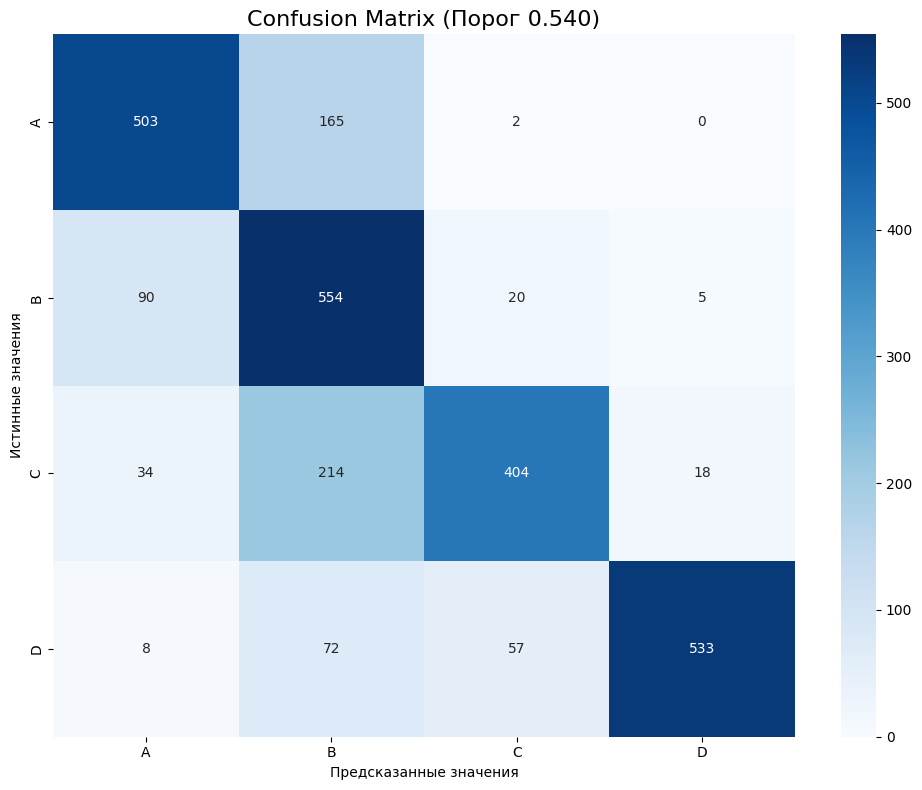

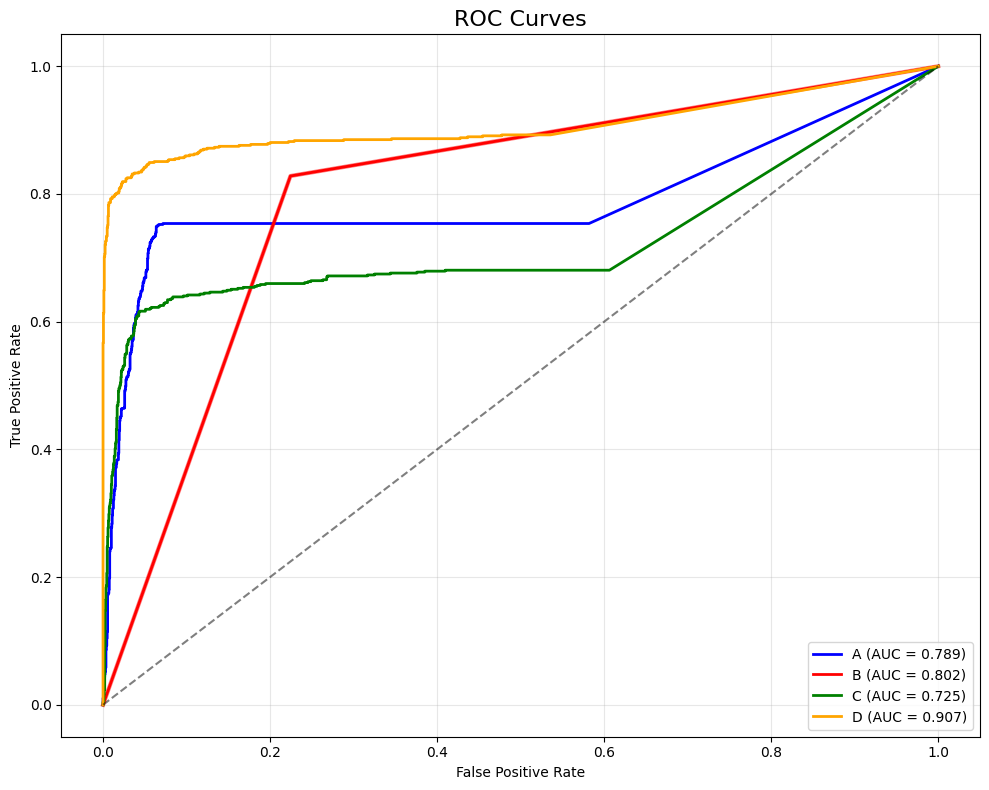

<Figure size 1000x600 with 0 Axes>

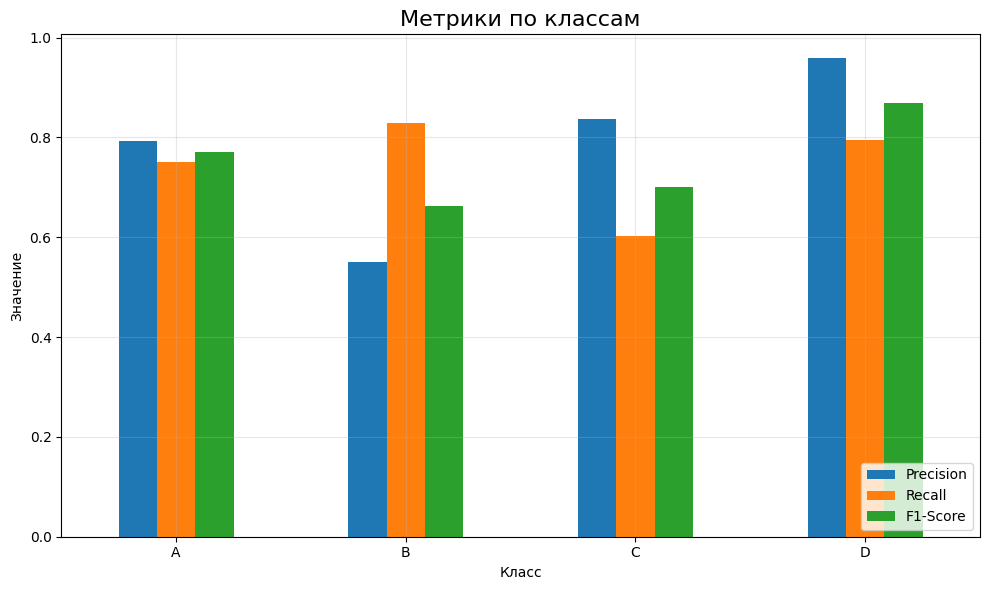

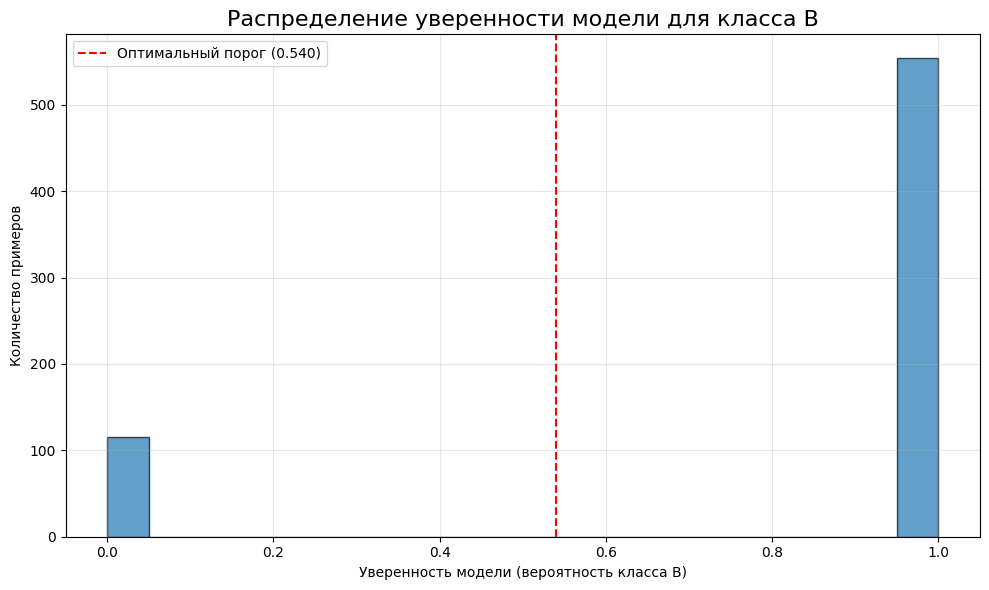


АНАЛИЗ ОШИБОК КЛАССА B
Класс B в тестовой выборке: 669 примеров
  Правильно классифицированы: 554 (82.8%)
  Ошибочно классифицированы: 115 (17.2%)

Куда ошибочно классифицированы примеры класса B:
  A: 90 примеров (78.3%)
  C: 20 примеров (17.4%)
  D: 5 примеров (4.3%)

Анализ уверенности модели для класса B:
  Средняя уверенность для правильных B: 1.0000
  Средняя уверенность для ошибочных B: 0.0000
  Минимальная уверенность: 0.0000
  Максимальная уверенность: 1.0000

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
Финальная модель сохранена как 'final_optimized_model.keras'
Предсказания сохранены в 'final_predictions.csv'
Конфигурация модели сохранена в 'model_config.csv'

ИТОГОВЫЕ РЕКОМЕНДАЦИИ:
1. Оптимальный порог для класса B: 0.540
2. Лучшая стратегия: Порог 0.540
3. Recall класса B: 0.7955
4. F1-score класса B: 0.6619

Для дальнейшего улучшения можно:
  - Попробовать разные значения порога (0.4-0.6)
  - Использовать ансамбль нескольких моделей
  - Добавить новые признаки или применить feature engineeri

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# === 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА ===
df = pd.read_csv('bodyPerformance.csv')

print(f"Исходный размер: {df.shape}")

# Проверка на пропуски
print(f"Пропуски в данных:\n{df.isnull().sum()}")

# Если есть пропуски
if df.isnull().sum().any():
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if col != 'class':
            df[col] = df[col].fillna(df[col].mode()[0])

# Удаляем полные дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")

# Анализ распределения классов
print("\nРаспределение классов:")
print(df['class'].value_counts())
print(f"Баланс классов: {df['class'].value_counts(normalize=True).values}")

# === 2. КОДИРОВАНИЕ И МАСШТАБИРОВАНИЕ ===
for col in df.select_dtypes(include=['object']).columns:
    if col != 'class':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

le = LabelEncoder()
y = le.fit_transform(df['class'])
class_names = le.classes_
n_classes = len(class_names)
print(f"\nКлассы: {class_names}")

X = df.drop(columns=['class'])

# Масштабирование
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# === 3. РАЗБИЕНИЕ С АКЦЕНТОМ НА КЛАСС B ===
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Балансировка классов с SMOTE
if len(np.unique(y_train)) > 1:
    smote = SMOTE(random_state=42, k_neighbors=min(4, len(y_train)-1))
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nПосле SMOTE: {X_train.shape}")

# === 4. СПЕЦИАЛЬНЫЕ ВЕСА ДЛЯ КЛАССА B ===
print("\nАнализ распределения классов в тренировочной выборке:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Класс {class_names[cls]}: {count} примеров ({count/len(y_train)*100:.1f}%)")

# СТРАТЕГИЯ: Сильное увеличение веса для класса B
y_train_counts = np.bincount(y_train)
total = len(y_train)

# Базовые веса (обратно пропорциональные частоте)
base_weights = total / (n_classes * y_train_counts)

# Увеличиваем вес для класса B в 3 раза
boost_factor_b = 3.0
class_weights_custom = {}
for i in range(n_classes):
    if i == 1:  # Класс B
        class_weights_custom[i] = base_weights[i] * boost_factor_b
    else:
        class_weights_custom[i] = base_weights[i]

print(f"\nВеса классов:")
for i, cls_name in enumerate(class_names):
    print(f"  {cls_name}: {class_weights_custom[i]:.3f}")

# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# === 5. ФУНКЦИИ ДЛЯ РАБОТЫ С ПОРОГОМ ===
def apply_threshold_to_predictions(y_pred_proba, class_names, target_class='B', threshold=0.5):
    """Применяет порог к предсказаниям для целевого класса"""
    target_idx = np.where(class_names == target_class)[0][0]
    
    # Копируем вероятности
    y_pred_proba_thresholded = y_pred_proba.copy()
    
    # Если вероятность целевого класса выше порога, усиливаем её
    for i in range(len(y_pred_proba)):
        if y_pred_proba[i, target_idx] > threshold:
            # Увеличиваем вероятность целевого класса
            y_pred_proba_thresholded[i, target_idx] = 1.0
            # Уменьшаем вероятности других классов
            for j in range(n_classes):
                if j != target_idx:
                    y_pred_proba_thresholded[i, j] = 0.0
        else:
            # Нормализуем оставшиеся вероятности
            mask = np.ones(n_classes, dtype=bool)
            mask[target_idx] = False
            remaining_proba = y_pred_proba_thresholded[i, mask]
            if remaining_proba.sum() > 0:
                y_pred_proba_thresholded[i, mask] = remaining_proba / remaining_proba.sum()
            y_pred_proba_thresholded[i, target_idx] = 0.0
    
    return y_pred_proba_thresholded

def find_optimal_threshold_improved(model, X_val, y_val, class_names, target_class='B'):
    """Находит оптимальный порог для целевого класса"""
    target_idx = np.where(class_names == target_class)[0][0]
    
    # Получаем вероятности для валидационной выборки
    y_pred_proba_val = model.predict(X_val, verbose=0)
    
    # Перебираем пороги
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    best_results = {}
    
    for threshold in thresholds:
        # Применяем порог
        y_pred_proba_th = apply_threshold_to_predictions(
            y_pred_proba_val, class_names, target_class, threshold
        )
        y_pred_th = np.argmax(y_pred_proba_th, axis=1)
        
        # Вычисляем метрики для целевого класса
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_val, y_pred_th, labels=[target_idx], average='macro'
        )
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_results = {
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'y_pred': y_pred_th.copy()
            }
    
    print(f"Найден оптимальный порог для {target_class}: {best_threshold:.3f}")
    print(f"Метрики с этим порогом: Precision={best_results['precision']:.4f}, "
          f"Recall={best_results['recall']:.4f}, F1={best_results['f1']:.4f}")
    
    return best_threshold, best_results

def smart_threshold_predictions(y_pred_proba, class_names, target_class='B', threshold=0.5):
    """Умное применение порога с сохранением нормализации"""
    target_idx = np.where(class_names == target_class)[0][0]
    n_classes = len(class_names)
    
    y_pred_proba_adjusted = y_pred_proba.copy()
    
    for i in range(len(y_pred_proba)):
        current_target_prob = y_pred_proba[i, target_idx]
        
        if current_target_prob > threshold:
            # Усиливаем целевой класс, но не до 1.0, чтобы сохранить некоторую неопределенность
            boost_factor = min(2.0, 1.0 / (current_target_prob + 1e-7))
            y_pred_proba_adjusted[i, target_idx] = current_target_prob * boost_factor
        else:
            # Ослабляем целевой класс
            y_pred_proba_adjusted[i, target_idx] = current_target_prob * 0.5
        
        # Нормализуем, чтобы сумма была равна 1
        y_pred_proba_adjusted[i] = y_pred_proba_adjusted[i] / y_pred_proba_adjusted[i].sum()
    
    return y_pred_proba_adjusted

# === 6. СПЕЦИАЛИЗИРОВАННАЯ АРХИТЕКТУРА ===
def create_b_class_focused_model(input_dim, n_classes):
    """Модель с акцентом на улучшение классификации класса B"""
    
    inputs = Input(shape=(input_dim,))
    
    # Первый блок - общие признаки
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Второй блок - более глубокие слои
    x = Dense(96, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # Третий блок
    x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Выходной слой
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Кастомная функция потерь с увеличенным весом для класса B
    def weighted_categorical_crossentropy(y_true, y_pred):
        weights = tf.constant([class_weights_custom[i] for i in range(n_classes)], dtype=tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Взвешенная кросс-энтропия
        loss = -tf.reduce_sum(weights * y_true * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(loss)
    
    model.compile(
        optimizer=Nadam(learning_rate=0.001),
        loss=weighted_categorical_crossentropy,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', multi_label=True)
        ]
    )
    
    return model

# === 7. КОЛЛБЭКИ ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_overall_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

# === 8. ОБУЧЕНИЕ МОДЕЛИ ===
print("\n" + "="*60)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("="*60)

# Создаем модель
model = create_b_class_focused_model(
    input_dim=X_train.shape[1],
    n_classes=n_classes
)

model.summary()

# Обучение
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=150,
    batch_size=64,
    class_weight=class_weights_custom,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# === 9. НАХОЖДЕНИЕ ОПТИМАЛЬНОГО ПОРОГА ===
print("\n" + "="*60)
print("НАХОЖДЕНИЕ ОПТИМАЛЬНОГО ПОРОГА ДЛЯ КЛАССА B")
print("="*60)

# Находим оптимальный порог
optimal_threshold, threshold_results = find_optimal_threshold_improved(
    model, X_val, y_val, class_names, target_class='B'
)

# === 10. ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ С РАЗНЫМИ СТРАТЕГИЯМИ ===
print("\n" + "="*60)
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

# Получаем базовые предсказания
y_pred_proba_base = model.predict(X_test, verbose=0)
y_pred_base = np.argmax(y_pred_proba_base, axis=1)

print("\n1. БАЗОВАЯ МОДЕЛЬ (без порога):")
print("-" * 60)
print(classification_report(y_test, y_pred_base, target_names=class_names, digits=4))

# Применяем оптимальный порог
y_pred_proba_thresholded = apply_threshold_to_predictions(
    y_pred_proba_base, class_names, 'B', optimal_threshold
)
y_pred_thresholded = np.argmax(y_pred_proba_thresholded, axis=1)

print(f"\n2. С ОПТИМАЛЬНЫМ ПОРОГОМ ({optimal_threshold:.3f}):")
print("-" * 60)
print(classification_report(y_test, y_pred_thresholded, target_names=class_names, digits=4))

# Умное применение порога
y_pred_proba_smart = smart_threshold_predictions(
    y_pred_proba_base, class_names, 'B', optimal_threshold
)
y_pred_smart = np.argmax(y_pred_proba_smart, axis=1)

print(f"\n3. С УМНЫМ ПОРОГОМ ({optimal_threshold:.3f}):")
print("-" * 60)
print(classification_report(y_test, y_pred_smart, target_names=class_names, digits=4))

# === 11. СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===
print("\n" + "="*60)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ДЛЯ КЛАССА B")
print("="*60)

strategies = {
    'Без порога': y_pred_base,
    f'С порогом {optimal_threshold:.3f}': y_pred_thresholded,
    f'Умный порог {optimal_threshold:.3f}': y_pred_smart
}

results_comparison = []

for strategy_name, y_pred_strategy in strategies.items():
    # Метрики для класса B
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_strategy, labels=[1], average='macro'  # 1 - это класс B
    )
    
    # Общие метрики
    accuracy = accuracy_score(y_test, y_pred_strategy)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_strategy)
    
    results_comparison.append({
        'Стратегия': strategy_name,
        'Accuracy': f"{accuracy:.4f}",
        'Balanced Acc': f"{balanced_acc:.4f}",
        'Precision (B)': f"{precision:.4f}",
        'Recall (B)': f"{recall:.4f}",
        'F1 (B)': f"{f1:.4f}"
    })

comparison_df = pd.DataFrame(results_comparison)
print("\nСравнение стратегий:")
print(comparison_df.to_string(index=False))

# === 12. ОПРЕДЕЛЯЕМ ЛУЧШУЮ СТРАТЕГИЮ ===
print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Вычисляем F1 для каждой стратегии
f1_scores = []
for y_pred_strategy in [y_pred_base, y_pred_thresholded, y_pred_smart]:
    _, _, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_strategy, labels=[1], average='macro'
    )
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_strategies = ['Без порога', f'Порог {optimal_threshold:.3f}', f'Умный порог {optimal_threshold:.3f}']

print(f"\nЛучшая стратегия по F1 для класса B: {best_strategies[best_idx]} (F1 = {f1_scores[best_idx]:.4f})")

# Используем лучшую стратегию
if best_idx == 0:
    y_pred_final = y_pred_base
    y_pred_proba_final = y_pred_proba_base
    print("Рекомендация: использовать модель без порога")
elif best_idx == 1:
    y_pred_final = y_pred_thresholded
    y_pred_proba_final = y_pred_proba_thresholded
    print(f"Рекомендация: использовать жесткий порог {optimal_threshold:.3f}")
else:
    y_pred_final = y_pred_smart
    y_pred_proba_final = y_pred_proba_smart
    print(f"Рекомендация: использовать умный порог {optimal_threshold:.3f}")

# === 13. ДЕТАЛЬНЫЙ ОТЧЕТ ДЛЯ ЛУЧШЕЙ СТРАТЕГИИ ===
print("\n" + "="*60)
print(f"ФИНАЛЬНЫЙ ОТЧЕТ ({best_strategies[best_idx]})")
print("="*60)

print(classification_report(y_test, y_pred_final, target_names=class_names, digits=4))

# Общие метрики
accuracy = accuracy_score(y_test, y_pred_final)
balanced_acc = balanced_accuracy_score(y_test, y_pred_final)
mcc = matthews_corrcoef(y_test, y_pred_final)
kappa = cohen_kappa_score(y_test, y_pred_final)
auc = roc_auc_score(y_test_cat, y_pred_proba_final, multi_class='ovr', average='weighted')

print(f"\nОбщие метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC: {auc:.4f}")

# === 14. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# 14.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix ({best_strategies[best_idx]})', fontsize=16)
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.savefig('final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 14.2 ROC Curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_proba_final[:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], y_pred_proba_final[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})', 
             linewidth=2, color=colors[i])
    
    # Особо выделяем класс B
    if i == 1:
        plt.plot(fpr, tpr, linewidth=3, color=colors[i], alpha=0.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 14.3 Сравнение метрик по классам
metrics_by_class = []
for i, cls in enumerate(class_names):
    precision = precision_score(y_test, y_pred_final, labels=[i], average='macro')
    recall = recall_score(y_test, y_pred_final, labels=[i], average='macro')
    f1 = f1_score(y_test, y_pred_final, labels=[i], average='macro')
    
    metrics_by_class.append({
        'Класс': cls,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_by_class)
metrics_df = metrics_df.set_index('Класс')

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Метрики по классам', fontsize=16)
plt.ylabel('Значение')
plt.xlabel('Класс')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_by_class_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 14.4 Анализ уверенности для класса B
b_probas = y_pred_proba_final[y_test == 1, 1]  # Вероятности для класса B

plt.figure(figsize=(10, 6))
plt.hist(b_probas, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
            label=f'Оптимальный порог ({optimal_threshold:.3f})')
plt.xlabel('Уверенность модели (вероятность класса B)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели для класса B', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('b_class_confidence_final.png', dpi=300, bbox_inches='tight')
plt.show()

# === 15. АНАЛИЗ ОШИБОК ===
print("\n" + "="*60)
print("АНАЛИЗ ОШИБОК КЛАССА B")
print("="*60)

# Находим индексы примеров класса B в тестовой выборке
b_test_indices = np.where(y_test == 1)[0]
b_correct = []
b_incorrect = []

for idx in b_test_indices:
    if y_pred_final[idx] == 1:
        b_correct.append(idx)
    else:
        b_incorrect.append(idx)

print(f"Класс B в тестовой выборке: {len(b_test_indices)} примеров")
print(f"  Правильно классифицированы: {len(b_correct)} ({len(b_correct)/len(b_test_indices)*100:.1f}%)")
print(f"  Ошибочно классифицированы: {len(b_incorrect)} ({len(b_incorrect)/len(b_test_indices)*100:.1f}%)")

if b_incorrect:
    print("\nКуда ошибочно классифицированы примеры класса B:")
    incorrect_predictions = y_pred_final[b_incorrect]
    unique, counts = np.unique(incorrect_predictions, return_counts=True)
    for pred_class, count in zip(unique, counts):
        print(f"  {class_names[pred_class]}: {count} примеров ({count/len(b_incorrect)*100:.1f}%)")

# Анализ уверенности модели
print("\nАнализ уверенности модели для класса B:")
print(f"  Средняя уверенность для правильных B: {np.mean(y_pred_proba_final[b_correct, 1]):.4f}")
if b_incorrect:
    print(f"  Средняя уверенность для ошибочных B: {np.mean(y_pred_proba_final[b_incorrect, 1]):.4f}")
print(f"  Минимальная уверенность: {np.min(b_probas):.4f}")
print(f"  Максимальная уверенность: {np.max(b_probas):.4f}")

# === 16. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
print("\n" + "="*60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Сохраняем модель
model.save('final_optimized_model.keras')
print("Финальная модель сохранена как 'final_optimized_model.keras'")

# Сохраняем предсказания
predictions_df = pd.DataFrame({
    'true_class': y_test,
    'true_class_name': [class_names[i] for i in y_test],
    'predicted_class': y_pred_final,
    'predicted_class_name': [class_names[i] for i in y_pred_final],
    'confidence_A': y_pred_proba_final[:, 0],
    'confidence_B': y_pred_proba_final[:, 1],
    'confidence_C': y_pred_proba_final[:, 2],
    'confidence_D': y_pred_proba_final[:, 3],
    'max_confidence': np.max(y_pred_proba_final, axis=1)
})

# Добавляем информацию о корректности предсказания
predictions_df['correct'] = predictions_df['true_class'] == predictions_df['predicted_class']

# Сохраняем в CSV
predictions_df.to_csv('final_predictions.csv', index=False)
print("Предсказания сохранены в 'final_predictions.csv'")

# Сохраняем веса классов и порог
config_df = pd.DataFrame({
    'parameter': ['weight_A', 'weight_B', 'weight_C', 'weight_D', 'optimal_threshold_B'],
    'value': [
        class_weights_custom[0],
        class_weights_custom[1],
        class_weights_custom[2],
        class_weights_custom[3],
        optimal_threshold
    ]
})
config_df.to_csv('model_config.csv', index=False)
print("Конфигурация модели сохранена в 'model_config.csv'")

print("\n" + "="*60)
print("ИТОГОВЫЕ РЕКОМЕНДАЦИИ:")
print("="*60)
print(f"1. Оптимальный порог для класса B: {optimal_threshold:.3f}")
print(f"2. Лучшая стратегия: {best_strategies[best_idx]}")
print(f"3. Recall класса B: {recall:.4f}")
print(f"4. F1-score класса B: {f1_scores[best_idx]:.4f}")
print("\nДля дальнейшего улучшения можно:")
print("  - Попробовать разные значения порога (0.4-0.6)")
print("  - Использовать ансамбль нескольких моделей")
print("  - Добавить новые признаки или применить feature engineering")
print("  - Использовать более сложные архитектуры нейросетей")